In [1]:
import os
import sys
import glob
import warnings
import uuid
from collections import defaultdict
from tqdm import tqdm
import numpy as np # Can't install NumPy 2.2.2 which is what the pkls were saved with
import pandas as pd # 'v2.2.3'
import anndata as ad
from pyexeggutor import (
    build_logger,
    write_pickle,
    read_pickle,
    format_header,
    read_list,
)

# Niche
import optuna
import joblib

# PyData
from scipy.spatial.distance import (
    pdist, 
    squareform,
)
from sklearn.neighbors import (
    kneighbors_graph, 
    KNeighborsTransformer,
)
from sklearn.metrics import (
    pairwise_distances,
    silhouette_score, 
    
    # silhouette_samples, 
    # completeness_score,
)
from sklearn.model_selection import train_test_split



# from metabolic_niche_space.manifold import DiffusionMaps # Shortcut: from datafold.dynfold import DiffusionMaps
from datafold.dynfold import DiffusionMaps

import pacmap

from clairvoyance.utils import ( 
    compile_parameter_space, # Can this be in Clairvoyance
    check_parameter_space,
)
# from sklearn.cluster import (
#     HDBSCAN, # Not included in sklearn <1.3
# )

import matplotlib.pyplot as plt

# Metabolic Niche Space
from metabolic_niche_space.neighbors import KNeighborsKernel
from metabolic_niche_space.manifold import (
    NicheSpace,
    HierarchicalNicheSpace,
    # DiffusionMapEmbedding,
)

from metabolic_niche_space.utils import (
    fast_groupby,
    is_square_symmetric, 
    stop_when_exceeding_trials,

    # compile_parameter_space,
)


/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pending:
* How many features should a genome require to be included in MNS?
    - 100
* What if you have the kernel_space parameter in params but not diffusionmap_space? 

In [2]:
%%time
# Data
df_quality = pd.read_csv("../data/quality.tsv.gz",sep="\t", index_col=0)

quality_label="completeness_gte90.contamination_lt5"
# quality_label="completeness_gte50.contamination_lt10"
output_directory=f"../data/cluster/mfc/{quality_label}"
os.makedirs(output_directory, exist_ok=True)

genome_to_clusterani = pd.read_csv(f"../data/training/{quality_label}/y.tsv.gz", sep="\t", index_col=0, header=None).iloc[:,0].astype("category")
X_genomic_traits = pd.read_csv(f"../data/training/{quality_label}/X.tsv.gz", sep="\t", index_col=0).astype(bool)
X_genomic_traits_clusterani = pd.read_csv(f"../data/training/{quality_label}/X_grouped.tsv.gz", sep="\t", index_col=0).astype(bool)
eukaryotes = read_list(f"../data/cluster/ani/eukaryotic/{quality_label}/organisms.list", set)
prokaryotes = read_list(f"../data/cluster/ani/prokaryotic/{quality_label}/organisms.list", set)

genome_to_taxonomy = pd.read_csv("../data/taxonomy.tsv.gz", sep="\t", index_col=0).iloc[:,0]
clusterani_to_taxonomy = pd.read_csv("../data/cluster/ani/cluster-ani_to_taxonomy.tsv.gz", sep="\t", index_col=0, header=None).iloc[:,0]
df_meta_mfc__genomes = pd.read_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genomes.with_openai.tsv.gz", sep="\t", index_col=0)
df_meta_mfc__slc = pd.read_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genome_clusters.with_openai.tsv.gz", sep="\t", index_col=0)

X_genomic_traits_mfc = X_genomic_traits_clusterani.groupby(df_meta_mfc__slc["id_cluster-mfc"]).sum() > 0
df_kegg = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-raw-veba-db-prod/VDB_v8.1/Annotate/KOfam/kegg-ortholog_metadata.tsv", sep="\t", index_col=0)
ko_to_description = df_kegg["definition"]

print("Number of genomes: {}, Number of features: {}, Number of SLCs: {}".format(*X_genomic_traits.shape, X_genomic_traits_clusterani.shape[0]))
# Number of genomes: 20377, Number of features: 2124, Number of SLCs: 6719

# CPU times: user 3.41 s, sys: 87.8 ms, total: 3.5 s
# Wall time: 3.5 s

Number of genomes: 20377, Number of features: 2124, Number of SLCs: 6719
CPU times: user 3.83 s, sys: 260 ms, total: 4.09 s
Wall time: 4.4 s


In [3]:
# pathway_kofam = list(filter(bool,open("/home/ec2-user/SageMaker/s3/newatlantis-raw-veba-db-prod/VDB_v8.1/Annotate/KOfam/kofam.pathways.list", "r").read().split("\n")))
# pathway_kofam_detected = sorted(set(pathway_kofam) & set(X_genomic_traits.columns), key=lambda x: int(x[1:]))
# X_genomic_traits.loc[:,pathway_kofam_detected].astype(int).to_csv(os.path.join(output_directory, "global.genomic_traits.kofam.bool-int.pathway_subset.tsv.gz"), sep="\t")
# X_genomic_traits_clusterani.loc[:,pathway_kofam_detected].astype(int).to_csv(os.path.join(output_directory, "global.genomic_traits.kofam.bool-int.cluster-ani.pathway_subset.tsv.gz"), sep="\t")

<Axes: xlabel='id_genome'>

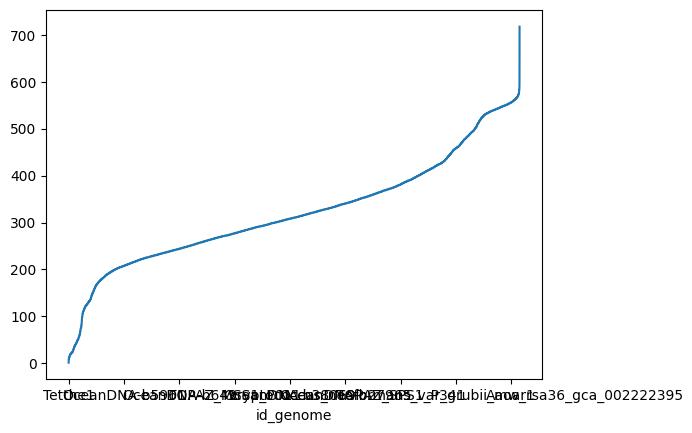

In [4]:
X_genomic_traits.sum(axis=1).sort_values().plot()

# pairwise_jaccard(X_genomic_traits.iloc[:100,:10].values)

In [17]:
# from collections.abc import Mapping

# def compile_parameter_space(trial, param_space):
#     params = dict()
#     for k, v in param_space.items():
#         if isinstance(v, list):
#             suggestion_type = str(v[0])
#             suggest = getattr(trial, f"suggest_{suggestion_type}")
#             if suggestion_type in {"float", "int"}:
#                 if isinstance(v[-1], Mapping):
#                     suggestion = suggest(k, *v[1:-1], **v[-1])
#                 else:
#                     suggestion = suggest(k, *v[1:])

#             else:
#                 suggestion = suggest(k, *v[1:])
#             params[k] = suggestion
#         else:
#             params[k] = v
#     return params

In [14]:
# #!/usr/bin/env python
# import sys
# import os
# from tqdm import tqdm
# import numpy as np
# import pandas as pd
# import optuna
# from clairvoyance.utils import compile_parameter_space

# def fast_groupby(X: pd.DataFrame, y: pd.Series, method: str = "sum"):
#     if not np.all(X.shape[0] == y.size):
#         raise IndexError("X.shape[0] must equal y.size")
#     if not np.all(X.index == y.index):
#         raise IndexError("X.index must equal y.index")
#     if not isinstance(y, pd.CategoricalDtype):
#         y = y.astype("category")
    
#     # Convert y to numeric indices
#     unique_classes, y_indices = np.unique(y, return_inverse=True)
    
#     arrays = []
#     for col in tqdm(X.columns, "Grouping rows by", unit=" column"):
#         summed_values = np.bincount(y_indices, weights=X[col].values, minlength=len(unique_classes))
        
#         if method == "sum":
#             result_values = summed_values
#         elif method == "mean":
#             counts = np.bincount(y_indices, minlength=len(unique_classes))
#             result_values = np.divide(summed_values, counts, out=np.zeros_like(summed_values), where=counts > 0)
#         else:
#             raise ValueError("Unsupported method. Use 'sum' or 'mean'.")
        
#         arrays.append(result_values)
    
#     X_grouped = np.vstack(arrays).T
#     return pd.DataFrame(X_grouped, index=unique_classes, columns=X.columns)

# # def compile_parameter_space(trial, param_space): # This should be merged with `compile_parameter_space` from clairvoyance
# #     params = dict()
# #     for k, v in param_space.items():
# #         if isinstance(v, list):
# #             suggestion_type = v[0]
# #             if isinstance(suggestion_type, type):
# #                 suggestion_type = suggestion_type.__name__
# #             suggest = getattr(trial, f"suggest_{suggestion_type}")
# #             suggestion = suggest(k, v[1], v[2])
# #         else:
# #             suggestion = v
# #         params[k] = suggestion
# #     return params

# def is_square_symmetric(matrix, tol=1e-8):
#     """Check if a matrix is square and symmetric."""
#     matrix = np.array(matrix)  # Ensure it's a NumPy array
#     return matrix.shape[0] == matrix.shape[1] and np.allclose(matrix, matrix.T, atol=tol)

# def stop_when_exceeding_trials(n_trials, logger):
#     def callback(study, trial):
#         """
#         Callback that stops optimization if the total number of trials exceeds `n_trials`.
#         """
#         finished_trial_states = [
#             optuna.trial.TrialState.COMPLETE, 
#             optuna.trial.TrialState.FAIL, 
#             optuna.trial.TrialState.RUNNING,
#         ]

#         total_completed_trials = sum(1 for t in study.trials if t.state in finished_trial_states)

#         if total_completed_trials >= n_trials:
#             logger.warning(f"[Callback] Stopping optimization: {total_completed_trials} trials reached (limit={n_trials})")
#             study.stop()
    
#     return callback  # Return the function with access to `n_trials` and `logger`


In [6]:
# class NicheSpace(object):
#     """
#     # Usage:
#     import numpy as np
#     import pandas as pd
#     from sklearn.datasets import make_classification

#     # Generate synthetic dataset
#     X, y = make_classification(
#         n_samples=1000,        # Number of samples
#         n_features=100,        # Number of boolean features
#         n_informative=50,      # Number of informative features
#         n_redundant=25,        # Number of redundant features
#         n_repeated=0,          # No repeated features
#         n_classes=3,           # Number of classes
#         n_clusters_per_class=1, # One cluster per class
#         weights=[0.33, 0.33, 0.34],  # Balanced class distribution
#         random_state=42        # For reproducibility
#     )

#     # Convert features to boolean (0 or 1) using a threshold at 0
#     X_boolean = (X > 0).astype(int)

#     # Create DataFrame
#     df = pd.DataFrame(X_boolean, columns=[f'Feature_{i+1}' for i in range(100)])
#     df['Class'] = y  # Add class labels

#     y = df.pop("Class")
#     X = df > 0

#     model = NicheSpace(n_trials=3, minimum_nfeatures=1)
#     model.fit(X,y)

#     """
#     def __init__(
#         self, 
#         # General
#         name:str=None,
#         observation_type:str=None,
#         feature_type:str=None,
#         class_type:str=None,
#         minimum_nfeatures:int=100,

#         # Diffusion Maps
#         kernel_distance_metric:str="jaccard",
#         # scoring_method:str="silhouette", # or IICR
#         scoring_distance_metric:str="euclidean",
#         n_neighbors=[int, 10, 100],
#         n_components=[int, 10, 100], # n_eigenpairs in DataFold. First diffusion map vector is steady-state so 1 is automatically added to any n_components value
#         alpha=[float, 0.0, 1.0],
#         scale_by_steadystate:bool=True,
#         niche_prefix="n",

#         # Optuna
#         n_trials=50,
#         n_jobs:int=1,
#         n_concurrent_trials:int=1,
#         initial_params:dict=None,
#         objective_direction="maximize",
#         checkpoint_directory=None,
#         study_timeout=None,
#         study_callbacks=None,
#         random_state=0,
#         verbose=1,
#         stream=sys.stdout,
#         ):
        
#         # General
#         if name is None:
#             name = str(uuid.uuid4())
            
#         self.name = name
#         self.observation_type = observation_type
#         self.feature_type = feature_type
#         self.class_type = class_type
#         self.minimum_nfeatures = minimum_nfeatures
        
#         # Diffusion Maps
#         self.kernel_distance_metric = kernel_distance_metric
#         # self.scoring_method = scoring_method
#         self.scoring_distance_metric = scoring_distance_metric
#         self.scale_by_steadystate = scale_by_steadystate
#         self.niche_prefix = niche_prefix
        
#         # Optuna
#         self.n_jobs = n_jobs
#         self.n_trials = n_trials
#         self.n_concurrent_trials = n_concurrent_trials
#         self.initial_params = initial_params
#         self.checkpoint_directory = checkpoint_directory
#         self.random_state = random_state
#         self.study_timeout = study_timeout
#         if study_callbacks is None:
#             study_callbacks = []
#         self.study_callbacks = study_callbacks
#         self.objective_direction = objective_direction

#         # Hyperparameters
#         self.is_tuned = True

#         if isinstance(n_neighbors, list):
#             self.is_tuned = False
#         self.n_neighbors = n_neighbors
        
#         if isinstance(n_components, list):
#             self.is_tuned = False
#         self.n_components = n_components
        
#         if isinstance(alpha, list):
#             self.is_tuned = False
#         self.alpha = alpha
        
#         self.param_space = check_parameter_space(dict(
#             n_neighbors = self.n_neighbors,
#             n_components = self.n_components,
#             alpha = self.alpha,
#             ))
        
#         self.logger = build_logger(self.name, stream=stream)
#         self.verbose = verbose
#         self.is_fitted = False
        
#     def tune(
#         self,
#         X:pd.DataFrame,
#         y:pd.Series,
#         distance_matrix:np.array,
#         sampler, 
#         **study_kws,
#         ):

#         def _objective(trial):
#             try:

#                 # Compile parameters
#                 params = compile_parameter_space(
#                     trial, 
#                     self.param_space,
#                 )

#                 # Parameters
#                 n_neighbors = params["n_neighbors"]
#                 n_components = params["n_components"]
#                 alpha = params["alpha"]

#                 if n_neighbors >= X.shape[0]:
#                     return -1 #np.nan
#                 else:
#                     # Build kernel
#                     kernel = KNeighborsKernel( 
#                         metric=self.kernel_distance_metric, 
#                         n_neighbors=n_neighbors, 
#                         distance_matrix=distance_matrix, 
#                         copy_distance_matrix=False,
#                     )

#                     # Calculate Diffusion Maps using KNeighbors
#                     model = DiffusionMaps(kernel=kernel, n_eigenpairs=n_components+1, alpha=alpha)

#                     if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Fitting Diffision Map: n_neighbors={n_neighbors}, n_components={n_components}, alpha={alpha}")
#                     dmap = model.fit_transform(X)

#                     # Score
#                     if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Calculating silhouette score: n_neighbors={n_neighbors}, n_components={n_components}, alpha={alpha}")
#                     score = silhouette_score(dmap[:,1:], y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=None) # Ignore steady state vector

#                     return score

#             except Exception as e:
#                 self.logger.error(f"[Trial {trial.number}] Failed due to error: {e}. Marking as pruned.")
#                 raise optuna.TrialPruned()  # Prevents skipping trials

#             finally:
#                 if self.checkpoint_directory:
#                     joblib.dump(study, os.path.join(self.checkpoint_directory, f"{self.name}.Optuna.{self.__class__.__name__}.pkl"))  # Save checkpoint

#         # Sampler
#         if sampler is None:
#             sampler = optuna.samplers.TPESampler(seed=self.random_state)
        
#         # Study
#         study_params = {
#             "direction":self.objective_direction, 
#             "study_name":self.name, 
#             "sampler":sampler, 
#             **study_kws,
#         }
        
#         # Checkpoints
#         study = None
#         if self.checkpoint_directory:
#             if not os.path.exists(self.checkpoint_directory):
#                 if self.verbose > 1: self.logger.info(f"Creating checkpoint directory: {self.checkpoint_directory}")
#                 os.makedirs(self.checkpoint_directory)
        
#             serialized_checkpoint_filepath = os.path.join(self.checkpoint_directory, f"{self.name}.Optuna.{self.__class__.__name__}.pkl")

#             if os.path.exists(serialized_checkpoint_filepath):
#                 if self.verbose > 1: self.logger.info(f"[Loading] Checkpoint file: {serialized_checkpoint_filepath}")
#                 study = joblib.load(serialized_checkpoint_filepath)
#             else:
#                 if self.verbose > 1: self.logger.info(f"[Creating] Checkpoint file: {serialized_checkpoint_filepath}")

#         if study is None:
#             study = optuna.create_study(**study_params)


#         if self.initial_params:
#             if self.verbose > 1: self.logger.info(f"Adding initial parameters to study: {self.initial_params}")
#             study.enqueue_trial(self.initial_params, user_attrs={"memo": "initial_params"}, skip_if_exists=True)
            
#         # Optimize
#         callback_fn = stop_when_exceeding_trials(self.n_trials, self.logger)
#         study.optimize(
#             _objective, 
#             n_trials=self.n_trials, 
#             n_jobs=self.n_concurrent_trials,
#             timeout=self.study_timeout, 
#             show_progress_bar=self.verbose >= 2, 
#             callbacks=self.study_callbacks + [stop_when_exceeding_trials], 
#             gc_after_trial=True,
#         )

#         return study


#     def fit(
#         self,
#         X:pd.DataFrame,
#         y:pd.Series,
#         distance_matrix:np.array=None,
#         sampler=None,
#         copy=True,
#         **study_kws,
#         ):

#         # Check inputs
#         if not np.all(X.shape[0] == y.size):
#             raise IndexError("X.shape[0] must equal y.size")
#         if not np.all(X.index == y.index):
#             raise IndexError("X.index must equal y.index")
#         if not isinstance(y, pd.CategoricalDtype):
#             y = y.astype("category")
#         self.X_ = X.copy()
#         self.y_ = y.copy()

            
#         # Minimum number of features
#         if self.minimum_nfeatures > 0:
#             if self.verbose > 0:
#                 self.logger.info(f"[Start] Filtering observations and classes below feature threshold: {self.minimum_nfeatures}")

#             number_of_features_per_observation = (X > 0).sum(axis=1)
#             observations_passed_qc = number_of_features_per_observation.index[number_of_features_per_observation >= self.minimum_nfeatures]

#             y = y.loc[observations_passed_qc]
#             X = X.loc[observations_passed_qc]
#             if self.verbose > 0:
#                 self.logger.info(f"[Dropping] N = {sum(number_of_features_per_observation < self.minimum_nfeatures)} observations")
#                 self.logger.info(f"[Remaining] N = {y.unique()} classes")
#                 self.logger.info(f"[Remaining] N = {X.shape[0]} observations")
#                 self.logger.info(f"[Remaining] N = {X.shape[1]} features")
#                 self.logger.info(f"[End] Filtering observations and classes below feature threshold")
            
#         # Dtype
#         if self.kernel_distance_metric == "jaccard":
#             X = X.astype(bool)
            
#         # Distance matrix
#         if distance_matrix is None:
#             if self.verbose > 0:
#                 self.logger.info("[Start] Processing distance matrix")
#             if self.kernel_distance_metric == "euclidean":
#                 distance_matrix = squareform(pdist(X.values, metric=self.kernel_distance_metric))
#             else:
#                 distance_matrix = pairwise_distances(X=X.values, metric=self.kernel_distance_metric, n_jobs=self.n_jobs)
            
#         if len(distance_matrix.shape) == 1:
#             distance_matrix = squareform(distance_matrix)
#         if self.verbose > 0:
#             self.logger.info("[End] Processing distance matrix")

#         # Store
#         self.classes_ = y.cat.categories
#         if copy:
#             self.X_ = X.copy()
#             self.y_ = y.copy()
        
#         # Tune
#         if not self.is_tuned:
#             if self.verbose > 0:
#                 self.logger.info("[Begin] Hyperparameter Tuning")
#             self.study_ = self.tune(
#                 X=X,
#                 y=y,
#                 distance_matrix=distance_matrix,
#                 sampler=sampler, 
#                 **study_kws,
#                 )
#             for k, v in self.study_.best_params.items():
#                 setattr(self,k,v)
#             if self.verbose > 0:
#                 self.logger.info(f"Tuned parameters (Score={self.study_.best_value}): {self.study_.best_params}")
#                 self.logger.info("[End] Hyperparameter Tuning")
#             self.is_tuned = True
            
#         # Build kernel
#         self.kernel_ = KNeighborsKernel( 
#             metric=self.kernel_distance_metric, 
#             n_neighbors=self.n_neighbors, 
#             distance_matrix=distance_matrix, 
#             copy_distance_matrix=True,
#         )

#         # Calculate Diffusion Maps using KNeighbors
#         self.model_ = DiffusionMaps(
#             kernel=self.kernel_, 
#             n_eigenpairs=self.n_components+1, 
#             alpha=self.alpha,
#         )
        
#         # Fit
#         dmap = self.model_.fit(X)

#         # Complete
#         dmap = self._parallel_transform(X, self.model_, progressbar_message=f"[Parallel Transformation] Initial data")
#         self.diffusion_coordinates_ = pd.DataFrame(dmap, index=X.index)
#         self.diffusion_coordinates_.columns = [f"{self.niche_prefix}0_steady-state"] + list(map(lambda i: f"{self.niche_prefix}{i}", range(1,dmap.shape[1])))
#         self.diffusion_coordinates_.index.name = self.observation_type
#         self.diffusion_coordinates_.columns.name = self.feature_type

#         # Scale
#         if self.scale_by_steadystate:
#             if self.verbose > 0: self.logger.info("Scaling embeddings by steady-state vector")
#             self.diffusion_coordinates_ = self._scale_by_first_column(self.diffusion_coordinates_)
#             # Score
#             if self.verbose > 0: self.logger.info("Calculating silhouette score for initial data")
#             self.score_ = silhouette_score(self.diffusion_coordinates_.values, y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=self.random_state)
#         else:
#             # Score
#             if self.verbose > 0: self.logger.info("Calculating silhouette score for initial data excluding steady-state vector")
#             self.score_ = silhouette_score(self.diffusion_coordinates_.values[:,1:], y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=self.random_state)
            
#         self.is_fitted = True

#         return self
    
    
#     def transform(
#         self,
#         X,
#         progressbar_message=None,
#         ):
#         if not self.is_fitted:
#             raise Exception("Please run .fit to build DiffusionMap model before continuing")
#         dmap = self._parallel_transform(self, X, model_, progressbar_message=progressbar_message)
#         if isinstance(X, pd.DataFrame):
#             X_dmap = pd.DataFrame(dmap, index=X.index)
#             X_dmap.columns = [f"{self.niche_prefix}0_steady-state"] + list(map(lambda i: f"{self.niche_prefix}{i}", range(1,dmap.shape[1])))
#             X_dmap.index.name = self.observation_type
#             X_dmap.columns.name = self.feature_type
#         else:
#             return dmap
        
#     def get_basis(self):
#         if not self.is_fitted:
#             raise Exception("Please run .fit to build DiffusionMap model before continuing")
#         return self.diffusion_coordinates_

#     @staticmethod
#     def _scale_by_first_column(X: pd.DataFrame) -> pd.DataFrame:
#         """
#         Scale all columns of a DataFrame (except the first one) by the first column.

#         Parameters:
#         -----------
#         X : pd.DataFrame
#             Input DataFrame where the first column serves as the divisor.

#         Returns:
#         --------
#         pd.DataFrame
#             A new DataFrame with the first column removed and the remaining columns scaled.
#         """
#         values = X.values  # Convert to NumPy array for efficiency
#         steady_state_vector = values[:, 0].reshape(-1, 1)  # Extract first column as divisor
#         scaled_values = values[:, 1:] / steady_state_vector  # Perform element-wise division

#         return pd.DataFrame(
#             scaled_values, 
#             index=X.index, 
#             columns=X.columns[1:]  # Remove first column name from new DataFrame
#         )

#     @staticmethod
#     def _process_row(model, row):
#         """Helper function to apply model.transform to a single row"""
#         return model.transform(row.reshape(1, -1))

#     def _parallel_transform(self, X, model, progressbar_message=None):
#         """Parallelizes the transformation using joblib"""
#         with warnings.catch_warnings():
#             warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")
#             output = joblib.Parallel(n_jobs=self.n_jobs, prefer="threads")(
#                 joblib.delayed(self._process_row)(model, row.values) for id, row in tqdm(X.iterrows(), desc=progressbar_message, total=X.shape[0], position=0, leave=True)
#             )
#             return np.vstack(output)

#     def to_file(self, filepath):
#         write_pickle(self, filepath)

#     # =======
#     # Built-in
#     # =======
#     def __repr__(self):
#         pad = 4
#         header = format_header(f"{self.__class__.__name__}(Name:{self.name}, ObservationType: {self.observation_type}, FeatureType: {self.feature_type}, ClassType: {self.class_type})", line_character="=")

#         n = len(header.split("\n")[0])
#         fields = [
#             header,
#             pad*" " + "* kernel_distance_metric: {}".format(self.kernel_distance_metric),
#             pad*" " + "* scoring_distance_metric: {}".format(self.scoring_distance_metric),
#             pad*" " + "* niche_prefix: {}".format(self.niche_prefix),
#             pad*" " + "* checkpoint_directory: {}".format(self.checkpoint_directory),
#         ]
                                                  
#         if self.is_tuned:
#             fields += [
#             pad*" " + "* n_neighbors: {}".format(self.n_neighbors),
#             pad*" " + "* n_components: {}".format(self.n_components),
#             pad*" " + "* alpha: {}".format(self.alpha),
#             pad*" " + "* score: {}".format(self.score_),
#             ]

#         return "\n".join(fields)


In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

# Generate synthetic dataset
X, y = make_classification(
    n_samples=1000,        # Number of samples
    n_features=100,        # Number of boolean features
    n_informative=50,      # Number of informative features
    n_redundant=25,        # Number of redundant features
    n_repeated=0,          # No repeated features
    n_classes=3,           # Number of classes
    n_clusters_per_class=1, # One cluster per class
    weights=[0.33, 0.33, 0.34],  # Balanced class distribution
    random_state=42        # For reproducibility
)

# Convert features to boolean (0 or 1) using a threshold at 0
X_boolean = (X > 0).astype(int)

# Create DataFrame
df = pd.DataFrame(X_boolean, columns=[f'Feature_{i+1}' for i in range(100)])
df['Class'] = y  # Add class labels

y = df.pop("Class")
X = df > 0

model = NicheSpace(n_trials=3, minimum_nfeatures=1, checkpoint_directory="checkpoints")
model.fit(X,y)


2025-02-20 01:42:01,606 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - [Start] Filtering observations and classes below feature threshold: 1
2025-02-20 01:42:01,611 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - [Dropping] N = 0 observations
2025-02-20 01:42:01,614 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - [Remaining] N = [2, 0, 1]
Categories (3, int64): [0, 1, 2] classes
2025-02-20 01:42:01,615 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - [Remaining] N = 1000 observations
2025-02-20 01:42:01,617 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - [Remaining] N = 100 features
2025-02-20 01:42:01,619 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - [End] Filtering observations and classes below feature threshold
2025-02-20 01:42:01,621 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - [Start] Processing distance matrix
2025-02-20 01:42:01,773 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - [End] Processing distance matrix
2025-02-20 01:42:01,774 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7

[I 2025-02-20 01:42:01,775] A new study created in memory with name: 2e08ca5a-67a7-40b5-b322-c48e46a55f7d
[I 2025-02-20 01:42:02,828] Trial 0 finished with value: 0.004204608013938112 and parameters: {'n_neighbors': 59, 'n_components': 75, 'alpha': 0.6027633760716439}. Best is trial 0 with value: 0.004204608013938112.
[I 2025-02-20 01:42:03,711] Trial 1 finished with value: 0.011760174491523643 and parameters: {'n_neighbors': 59, 'n_components': 48, 'alpha': 0.6458941130666561}. Best is trial 1 with value: 0.011760174491523643.
[I 2025-02-20 01:42:04,865] Trial 2 finished with value: 0.002436184049775515 and parameters: {'n_neighbors': 49, 'n_components': 91, 'alpha': 0.9636627605010293}. Best is trial 1 with value: 0.011760174491523643.


2025-02-20 01:42:04,981 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - Tuned parameters (Score=0.011760174491523643): {'n_neighbors': 59, 'n_components': 48, 'alpha': 0.6458941130666561}
2025-02-20 01:42:04,982 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - [End] Hyperparameter Tuning


[Parallel Transformation] Initial data: 100%|██████████| 1000/1000 [00:01<00:00, 578.43it/s]

2025-02-20 01:42:07,481 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - Scaling embeddings by steady-state vector
2025-02-20 01:42:07,482 - 2e08ca5a-67a7-40b5-b322-c48e46a55f7d - INFO - Calculating silhouette score for initial data


NicheSpace(Name:2e08ca5a-67a7-40b5-b322-c48e46a55f7d, ObservationType: None, FeatureType: None, ClassType: None)
    * kernel_distance_metric: jaccard
    * scoring_distance_metric: euclidean
    * niche_prefix: n
    * checkpoint_directory: checkpoints
    * n_neighbors: 59
    * n_components: 48
    * alpha: 0.6458941130666561
    * score: 0.015460333975544803

In [62]:
# class HierarchicalNicheSpace(object):
#     def __init__(
#         self, 
#         # General
#         name:str=None,
#         observation_type:str=None,
#         feature_type:str=None,
#         class1_type:str=None,
#         class2_type:str=None,
#         minimum_nfeatures:int=100,

#         # Diffusion Maps
#         kernel_distance_metric:str="jaccard",
#         # scoring_method:str="silhouette", # or IICR
#         scoring_distance_metric:str="euclidean",
#         n_neighbors:int="auto",
#         n_components:int="auto", # n_eigenpairs in DataFold. First diffusion map vector is steady-state so 1 is automatically added to any n_components value
#         alpha:float="auto",
#         scale_by_steadystate:bool=True,
#         niche_prefix="n",
#         robust_transform=True,

#         # Optuna
#         n_trials=50,
#         n_jobs:int=1,
#         n_concurrent_trials:int=1,
#         initial_params:dict=None,
#         objective_direction="maximize",
#         checkpoint_directory=None,
#         study_timeout=None,
#         study_callbacks=None,
#         random_state=0,
#         verbose=1,
#         stream=sys.stdout,
#         ):
        
#         # General
#         if name is None:
#             name = str(uuid.uuid4())
            
#         self.name = name
#         self.observation_type = observation_type
#         self.feature_type = feature_type
#         self.class1_type = class1_type
#         self.class2_type = class2_type
#         self.minimum_nfeatures = minimum_nfeatures
        
#         # Diffusion Maps
#         self.kernel_distance_metric = kernel_distance_metric
#         # self.scoring_method = scoring_method
#         self.scoring_distance_metric = scoring_distance_metric
#         self.scale_by_steadystate = scale_by_steadystate
#         self.niche_prefix = niche_prefix
#         self. robust_transform = robust_transform
        
#         # Optuna
#         self.n_jobs = n_jobs
#         self.n_trials = n_trials
#         self.n_concurrent_trials = n_concurrent_trials
#         self.initial_params = initial_params
#         self.checkpoint_directory = checkpoint_directory
#         self.random_state = random_state
#         self.study_timeout = study_timeout
#         if study_callbacks is None:
#             study_callbacks = []
#         self.study_callbacks = study_callbacks
#         self.objective_direction = objective_direction

#         # Hyperparameters
#         self.is_tuned = True
#         if n_neighbors == "auto":
#             n_neighbors = [int, 10, 100]
#             self.is_tuned = False
#         if isinstance(n_neighbors, list):
#             self.is_tuned = False
#         self.n_neighbors = n_neighbors
        
#         if n_components == "auto":
#             n_components = [int, 10, 100]
#             self.is_tuned = False
#         if isinstance(n_components, list):
#             self.is_tuned = False
#         self.n_components = n_components
        
#         if alpha == "auto":
#             alpha = [float, 0.0, 1.0]
#             self.is_tuned = False
#         if isinstance(alpha, list):
#             self.is_tuned = False
#         self.alpha = alpha
        
#         self._param_space = dict(
#             n_neighbors = self.n_neighbors,
#             n_components = self.n_components,
#             alpha = self.alpha,
#         )
        
#         self.logger = build_logger(self.name, stream=stream)
#         self.verbose = verbose
#         self.is_fitted = False
        
#     def tune(
#         self,
#         X:pd.DataFrame,
#         y:pd.Series,
#         X1:pd.DataFrame,
#         distance_matrix:np.array,
#         sampler, 
#         **study_kws,
#         ):

#         def _objective(trial):
#             try:

#                 # Compile parameters
#                 params = compile_parameter_space(
#                     trial, 
#                     self._param_space,
#                 )

#                 # Parameters
#                 n_neighbors = params["n_neighbors"]
#                 n_components = params["n_components"]
#                 alpha = params["alpha"]

#                 if n_neighbors >= X1.shape[0]:
#                     return -1 #np.nan
#                 else:
#                     # Build kernel
#                     kernel = KNeighborsKernel( 
#                         metric=self.kernel_distance_metric, 
#                         n_neighbors=n_neighbors, 
#                         distance_matrix=distance_matrix, 
#                         copy_distance_matrix=False,
#                     )

#                     # Calculate Diffusion Maps using KNeighbors
#                     model = DiffusionMaps(kernel=kernel, n_eigenpairs=n_components+1, alpha=alpha)

#                     if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Fitting Diffision Map: n_neighbors={n_neighbors}, n_components={n_components}, alpha={alpha}")
#                     dmap_X1 = model.fit_transform(X1)

#                     if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Transforming observations: n_neighbors={n_neighbors}, n_components={n_components}, alpha={alpha}")
#                     # dmap_X = model.transform(X)
#                     dmap_X = self._parallel_transform(X, model, progressbar_message=f"[Trial {trial.number}] Projecting initial data into diffusion space")

#                     # Score
#                     if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Calculating silhouette score: n_neighbors={n_neighbors}, n_components={n_components}, alpha={alpha}")
#                     score = silhouette_score(dmap_X[:,1:], y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=None) # Ignore steady state vector

#                     return score

#             except Exception as e:
#                 self.logger.error(f"[Trial {trial.number}] Failed due to error: {e}. Marking as pruned.")
#                 raise optuna.TrialPruned()  # Prevents skipping trials

#             finally:
#                 if self.checkpoint_directory:
#                     joblib.dump(study, os.path.join(self.checkpoint_directory, f"{self.name}.Optuna.{self.__class__.__name__}.pkl"))  # Save checkpoint

                
#         # Sampler
#         if sampler is None:
#             sampler = optuna.samplers.TPESampler(seed=self.random_state)
        
#         # Study
#         study_params = {
#             "direction":self.objective_direction, 
#             "study_name":self.name, 
#             "sampler":sampler, 
#             **study_kws,
#         }
        
#         # Checkpoints
#         study = None
#         if self.checkpoint_directory:
#             if not os.path.exists(self.checkpoint_directory):
#                 if self.verbose > 1: self.logger.info(f"Creating checkpoint directory: {self.checkpoint_directory}")
#                 os.makedirs(self.checkpoint_directory)
#             # if self.verbose > 1: self.logger.info("Creating sqlite database: {}".format(os.path.join(self.checkpoint_directory, f"{self.name}.db")))
#             # study_params["storage"] = "sqlite:///" + os.path.join(self.checkpoint_directory, f"{self.name}.db")
#             # study_params["load_if_exists"] = True
        
#             serialized_checkpoint_filepath = os.path.join(self.checkpoint_directory, f"{self.name}.Optuna.{self.__class__.__name__}.pkl")

#             if os.path.exists(serialized_checkpoint_filepath):
#                 if self.verbose > 1: self.logger.info(f"[Loading] Checkpoint file: {serialized_checkpoint_filepath}")
#                 study = joblib.load(serialized_checkpoint_filepath)
#             else:
#                 if self.verbose > 1: self.logger.info(f"[Creating] Checkpoint file: {serialized_checkpoint_filepath}")

#         if study is None:
#             study = optuna.create_study(**study_params)
        
#         if self.initial_params:
#             if self.verbose > 1: self.logger.info(f"Adding initial parameters to study: {self.initial_params}")
#             study.enqueue_trial(self.initial_params, user_attrs={"memo": "initial_params"}, skip_if_exists=True)
            
#         # Optimize
#         callback_fn = stop_when_exceeding_trials(self.n_trials, self.logger)

#         study.optimize(
#             _objective, 
#             n_trials=self.n_trials, 
#             n_jobs=self.n_concurrent_trials,
#             timeout=self.study_timeout, 
#             show_progress_bar=self.verbose >= 2, 
#             callbacks=self.study_callbacks + [callback_fn], 
#             gc_after_trial=True,
#         )

#         return study


#     def fit(
#         self,
#         X:pd.DataFrame,
#         y1:pd.Series,
#         y2:pd.Series=None,
#         distance_matrix:np.array=None,
#         sampler=None,
#         copy=True,
#         **study_kws,
#         ):

#         # Check inputs
#         ys = [y1]
#         if y2 is not None:
#             ys.append(y2)
#         for i, y in enumerate(ys, start=1):
#             y_name = f"y{i}"
#             if not np.all(X.shape[0] == y.size):
#                 raise IndexError(f"X.shape[0] must equal {y_name}.size")
#             if not np.all(X.index == y.index):
#                 raise IndexError(f"X.index must equal {y_name}.index")

#             setattr(self, f"{y_name}_", y.copy())
#         self.X_ = X.copy()
        
#         # Group values
#         X1 = fast_groupby(X, y1, method="sum")

#         if not set(X1.index) <= set(y1.unique()):
#             raise IndexError("X1.index must be ≤ y1 categories")
            
#         # Minimum number of features
#         if self.minimum_nfeatures > 0:
#             if self.verbose > 0:
#                 self.logger.info(f"[Start] Filtering observations and classes below feature threshold: {self.minimum_nfeatures}")

#             number_of_features_per_class = (X1 > 0).sum(axis=1)
#             index_classes = number_of_features_per_class.index[number_of_features_per_class > self.minimum_nfeatures]

#             mask = y1.map(lambda x: x not in index_classes)
#             y1 = y1.loc[~mask]
#             if y2 is not None:
#                 y2 = y2.loc[y1.index]
#             X = X.loc[y1.index]
#             if self.verbose > 0:
#                 self.logger.info(f"[Dropping] N = {X1.shape[0] - len(index_classes)} y1 classes")
#                 self.logger.info(f"[Dropping] N = {sum(mask)} observations")
#                 self.logger.info(f"[Remaining] N = {y1.nunique()} y1 classes")
#                 if y2 is not None:
#                     self.logger.info(f"[Remaining] N = {y2.nunique()} y2 classes")
#                 self.logger.info(f"[Remaining] N = {X.shape[0]} observations")
#                 self.logger.info(f"[Remaining] N = {X.shape[1]} features")
#                 self.logger.info(f"[End] Filtering observations and classes below feature threshold")
#             X1 = X1.loc[index_classes]
            
#         # Dtype
#         if self.kernel_distance_metric == "jaccard":
#             X = X.astype(bool)
#             X1 = X1.astype(bool)
            
#         # Distance matrix
#         if distance_matrix is None:
#             if self.verbose > 0:
#                 self.logger.info("[Start] Processing distance matrix")
#             if self.kernel_distance_metric == "euclidean":
#                 distance_matrix = squareform(pdist(X1, metric=self.kernel_distance_metric))
#             else:
#                 distance_matrix = pairwise_distances(X=X1.values, metric=self.kernel_distance_metric, n_jobs=self.n_jobs)
#         if len(distance_matrix.shape) == 1:
#             distance_matrix = squareform(distance_matrix)
#         if not distance_matrix.shape[0] == X1.shape[0]:
#             raise ValueError(f"distance_matrix.shape[0] ({distance_matrix.shape[0]}) does not match X1.shape[0] ({X1.shape[0]}).  This may be a result of automatic filtering.  If so, please filter before providing input or do not provide distance matrix")
#         if self.verbose > 0:
#             self.logger.info("[End] Processing distance matrix")

#         # Store
#         if not isinstance(y1, pd.CategoricalDtype):
#             y1 = y1.astype("category")
#         self.classes1_ = y1.cat.categories

#         if y2 is not None:
#             if not isinstance(y2, pd.CategoricalDtype):
#                 y2 = y2.astype("category")
#             self.classes2_ = y2.cat.categories

#         if copy:
#             self.X_ = X.copy()
#             self.y1_ = y1.copy()
#             if y2 is not None:
#                 self.y2_ = y2.copy()
#             self.X1_ = X1.copy()
        
#         if y2 is not None:
#             y = self.y2_.copy()
#         else:
#             y = self.y1_.copy()
#         # Tune
#         if not self.is_tuned:
#             if self.verbose > 0:
#                 self.logger.info("[Begin] Hyperparameter Tuning")

#             self.study_ = self.tune(
#                 X=X,
#                 y=y,
#                 X1=X1,
#                 distance_matrix=distance_matrix,
#                 sampler=sampler, 
#                 **study_kws,
#                 )
#             for k, v in self.study_.best_params.items():
#                 setattr(self,k,v)
#             if self.verbose > 0:
#                 self.logger.info(f"Tuned parameters (Score={self.study_.best_value}): {self.study_.best_params}")
#                 self.logger.info("[End] Hyperparameter Tuning")
#             self.is_tuned = True
            
#         # Build kernel
#         self.kernel_ = KNeighborsKernel( 
#             metric=self.kernel_distance_metric, 
#             n_neighbors=self.n_neighbors, 
#             distance_matrix=distance_matrix, 
#             copy_distance_matrix=True,
#         )

#         # Calculate Diffusion Maps using KNeighbors
#         self.model_ = DiffusionMaps(kernel=self.kernel_, n_eigenpairs=self.n_components+1, alpha=self.alpha)
        
#         # Fit
#         dmap = self.model_.fit(X1)

#         # Grouped
#         if self.robust_transform:
#             dmap = self._parallel_transform(X1, self.model_, progressbar_message=f"[Parallel Transformation] Grouped data") # More accurate to recalculate
#         self.diffusion_coordinates_grouped_ = pd.DataFrame(dmap, index=X1.index)
#         self.diffusion_coordinates_grouped_.columns = [f"{self.niche_prefix}0_steady-state"] + list(map(lambda i: f"{self.niche_prefix}{i}", range(1,dmap.shape[1])))
#         self.diffusion_coordinates_grouped_.index.name = self.class1_type
#         self.diffusion_coordinates_grouped_.columns.name = self.feature_type

#         # Complete
#         dmap = self._parallel_transform(X, self.model_, progressbar_message=f"[Parallel Transformation] Initial data")
#         self.diffusion_coordinates_initial_ = pd.DataFrame(dmap, index=X.index)
#         self.diffusion_coordinates_initial_.columns = [f"{self.niche_prefix}0_steady-state"] + list(map(lambda i: f"{self.niche_prefix}{i}", range(1,dmap.shape[1])))
#         self.diffusion_coordinates_initial_.index.name = self.observation_type
#         self.diffusion_coordinates_initial_.columns.name = self.feature_type

#         # Scale
#         if self.scale_by_steadystate:
#             if self.verbose > 0: self.logger.info("Scaling embeddings by steady-state vector")
#             self.diffusion_coordinates_grouped_ = self._scale_by_first_column(self.diffusion_coordinates_grouped_)
#             self.diffusion_coordinates_initial_ = self._scale_by_first_column(self.diffusion_coordinates_initial_)
#             # Score
#             if self.verbose > 0: self.logger.info("Calculating silhouette score for initial data")
#             self.score_ = silhouette_score(self.diffusion_coordinates_initial_.values, y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=self.random_state)
#         else:
#             # Score
#             if self.verbose > 0: self.logger.info("Calculating silhouette score for initial data excluding steady-state vector")
#             self.score_ = silhouette_score(self.diffusion_coordinates_initial_.values[:,1:], y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=self.random_state)
#         self.is_fitted = True

#         return self
    
#     def transform(
#         self,
#         X,
#         progressbar_message=None,
#         ):
#         if not self.is_fitted:
#             raise Exception("Please run .fit to build DiffusionMap model before continuing")
#         dmap = self._parallel_transform(self, X, model_, progressbar_message=progressbar_message)
#         if isinstance(X, pd.DataFrame):
#             X_dmap = pd.DataFrame(dmap, index=X.index)
#             X_dmap.columns = [f"{self.niche_prefix}0_steady-state"] + list(map(lambda i: f"{self.niche_prefix}{i}", range(1,dmap.shape[1])))
#             X_dmap.index.name = self.observation_type
#             X_dmap.columns.name = self.feature_type
#         else:
#             return dmap
        
        
#     def get_basis(self):
#         if not self.is_fitted:
#             raise Exception("Please run .fit to build DiffusionMap model before continuing")
#         X_basis = pd.concat([self.diffusion_coordinates_grouped_, self.diffusion_coordinates_initial_], axis=0)
#         y_basis = {
#             **self.y2_.to_dict(),
#             **dict(zip(self.y1_.values, self.y2_.values)),
#         }
#         y_basis = pd.Series(y_basis).loc[X_basis.index]
#         return X_basis, y_basis
    
#     @staticmethod
#     def _scale_by_first_column(X: pd.DataFrame) -> pd.DataFrame:
#         """
#         Scale all columns of a DataFrame (except the first one) by the first column.

#         Parameters:
#         -----------
#         X : pd.DataFrame
#             Input DataFrame where the first column serves as the divisor.

#         Returns:
#         --------
#         pd.DataFrame
#             A new DataFrame with the first column removed and the remaining columns scaled.
#         """
#         values = X.values  # Convert to NumPy array for efficiency
#         steady_state_vector = values[:, 0].reshape(-1, 1)  # Extract first column as divisor
#         scaled_values = values[:, 1:] / steady_state_vector  # Perform element-wise division

#         return pd.DataFrame(
#             scaled_values, 
#             index=X.index, 
#             columns=X.columns[1:]  # Remove first column name from new DataFrame
#         )

#     @staticmethod
#     def _process_row(model, row):
#         """Helper function to apply model.transform to a single row"""
#         return model.transform(row.reshape(1, -1))

#     def _parallel_transform(self, X, model, progressbar_message=None):
#         """Parallelizes the transformation using joblib"""
#         with warnings.catch_warnings():
#             warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")
#             output = joblib.Parallel(n_jobs=self.n_jobs, prefer="threads")(
#                 joblib.delayed(self._process_row)(model, row.values) for id, row in tqdm(X.iterrows(), desc=progressbar_message, total=X.shape[0], position=0, leave=True)
#             )
#             return np.vstack(output)

#     def to_file(self, filepath):
#         write_pickle(self, filepath)

#     # =======
#     # Built-in
#     # =======
#     def __repr__(self):
#         pad = 4
#         header = format_header(f"{self.__class__.__name__}(Name:{self.name}, ObservationType: {self.observation_type}, FeatureType: {self.feature_type}, Class1Type: {self.class1_type}, Class2Type: {self.class2_type})", line_character="=")

#         n = len(header.split("\n")[0])
#         fields = [
#             header,
#             pad*" " + "* kernel_distance_metric: {}".format(self.kernel_distance_metric),
#             pad*" " + "* scoring_distance_metric: {}".format(self.scoring_distance_metric),
#             pad*" " + "* niche_prefix: {}".format(self.niche_prefix),
#             pad*" " + "* checkpoint_directory: {}".format(self.checkpoint_directory),
#         ]
                                                  
#         if self.is_tuned:
#             fields += [
#             pad*" " + "* n_neighbors: {}".format(self.n_neighbors),
#             pad*" " + "* n_components: {}".format(self.n_components),
#             pad*" " + "* alpha: {}".format(self.alpha),
#             pad*" " + "* score: {}".format(self.score_),
#             ]

#         return "\n".join(fields)

In [4]:

X_test = X_genomic_traits.iloc[:1000,:]
y1_test = genome_to_clusterani.loc[X_test.index]
y2_test = df_meta_mfc__genomes["id_cluster-mfc"].loc[X_test.index]
assert np.all(y1_test.notnull())
assert np.all(y2_test.notnull())

mns_test = HierarchicalNicheSpace(
    observation_type="genome",
    feature_type="ko",
    class1_type="ani-cluster",
    class2_type="mfc-cluster",
    name="test",
    n_trials=3,
    verbose=10,
    # checkpoint_directory="checkpoints",
)
mns_test.fit(X_test, y1_test, y2_test)
# mns_test.qualitative_transform()

Grouping rows by: 100%|██████████| 2124/2124 [00:00<00:00, 34546.19 column/s]

2025-02-20 01:42:16,609 - test - INFO - [Start] Filtering observations and classes below feature threshold: 100
2025-02-20 01:42:16,625 - test - INFO - [Dropping] N = 6 y1 classes
2025-02-20 01:42:16,627 - test - INFO - [Dropping] N = 9 observations
2025-02-20 01:42:16,628 - test - INFO - [Remaining] N = 769 y1 classes
2025-02-20 01:42:16,629 - test - INFO - [Remaining] N = 48 y2 classes
2025-02-20 01:42:16,629 - test - INFO - [Remaining] N = 991 observations
2025-02-20 01:42:16,630 - test - INFO - [Remaining] N = 2124 features
2025-02-20 01:42:16,631 - test - INFO - [End] Filtering observations and classes below feature threshold
2025-02-20 01:42:16,637 - test - INFO - [Start] Processing distance matrix


2025-02-20 01:42:19,341 - test - INFO - [End] Processing distance matrix
2025-02-20 01:42:19,344 - test - INFO - [Begin] Hyperparameter Tuning


[I 2025-02-20 01:42:19,345] A new study created in memory with name: test
  0%|          | 0/3 [00:00<?, ?it/s]

2025-02-20 01:42:19,349 - test - INFO - [Trial 0] Fitting Diffision Map: n_neighbors=59, n_components=75, alpha=0.6027633760716439
2025-02-20 01:42:19,650 - test - INFO - [Trial 0] Transforming observations: n_neighbors=59, n_components=75, alpha=0.6027633760716439


[Trial 0] Projecting initial data into diffusion space: 100%|██████████| 991/991 [00:08<00:00, 116.08it/s]

2025-02-20 01:42:28,192 - test - INFO - [Trial 0] Calculating silhouette score: n_neighbors=59, n_components=75, alpha=0.6027633760716439



Best trial: 0. Best value: 0.053459:  33%|███▎      | 1/3 [00:09<00:18,  9.00s/it]

[I 2025-02-20 01:42:28,213] Trial 0 finished with value: 0.05345897427361011 and parameters: {'n_neighbors': 59, 'n_components': 75, 'alpha': 0.6027633760716439}. Best is trial 0 with value: 0.05345897427361011.
2025-02-20 01:42:28,350 - test - INFO - [Trial 1] Fitting Diffision Map: n_neighbors=59, n_components=48, alpha=0.6458941130666561
2025-02-20 01:42:28,544 - test - INFO - [Trial 1] Transforming observations: n_neighbors=59, n_components=48, alpha=0.6458941130666561


[Trial 1] Projecting initial data into diffusion space: 100%|██████████| 991/991 [00:08<00:00, 117.63it/s]

2025-02-20 01:42:36,972 - test - INFO - [Trial 1] Calculating silhouette score: n_neighbors=59, n_components=48, alpha=0.6458941130666561



Best trial: 0. Best value: 0.053459:  67%|██████▋   | 2/3 [00:17<00:08,  8.87s/it]

[I 2025-02-20 01:42:36,987] Trial 1 finished with value: 0.047773382918748046 and parameters: {'n_neighbors': 59, 'n_components': 48, 'alpha': 0.6458941130666561}. Best is trial 0 with value: 0.05345897427361011.
2025-02-20 01:42:37,130 - test - INFO - [Trial 2] Fitting Diffision Map: n_neighbors=49, n_components=91, alpha=0.9636627605010293
2025-02-20 01:42:37,513 - test - INFO - [Trial 2] Transforming observations: n_neighbors=49, n_components=91, alpha=0.9636627605010293


[Trial 2] Projecting initial data into diffusion space: 100%|██████████| 991/991 [00:08<00:00, 117.04it/s]

2025-02-20 01:42:45,984 - test - INFO - [Trial 2] Calculating silhouette score: n_neighbors=49, n_components=91, alpha=0.9636627605010293



Best trial: 0. Best value: 0.053459:  67%|██████▋   | 2/3 [00:26<00:08,  8.87s/it]

[I 2025-02-20 01:42:45,999] Trial 2 finished with value: 0.02090183546610645 and parameters: {'n_neighbors': 49, 'n_components': 91, 'alpha': 0.9636627605010293}. Best is trial 0 with value: 0.05345897427361011.
2025-02-20 01:42:46,126 - test - WARNING - [Callback] Stopping optimization: 3 trials reached (limit=3)


Best trial: 0. Best value: 0.053459: 100%|██████████| 3/3 [00:26<00:00,  8.93s/it]

2025-02-20 01:42:46,130 - test - INFO - Tuned parameters (Score=0.05345897427361011): {'n_neighbors': 59, 'n_components': 75, 'alpha': 0.6027633760716439}
2025-02-20 01:42:46,130 - test - INFO - [End] Hyperparameter Tuning



[Parallel Transformation] Initial data: 100%|██████████| 991/991 [00:08<00:00, 115.09it/s]

2025-02-20 01:43:01,731 - test - INFO - Scaling embeddings by steady-state vector
2025-02-20 01:43:01,732 - test - INFO - Calculating silhouette score for initial data


HierarchicalNicheSpace(Name:test, ObservationType: genome, FeatureType: ko, Class1Type: ani-cluster, Class2Type: mfc-cluster)
    * kernel_distance_metric: jaccard
    * scoring_distance_metric: euclidean
    * niche_prefix: n
    * checkpoint_directory: None
    * n_neighbors: 59
    * n_components: 75
    * alpha: 0.6027633760716439
    * score: 0.05319536927751588

In [58]:


class QualitativeSpace(object):
   
    def __init__(
        self, 
        # General
        name:str=None,
        observation_type:str=None,
        feature_type:str=None,
        class_type:str=None,
        
        # PaCMAP
        n_components:int=3, 
        n_neighbors:int="auto",
        MN_ratio:float="auto",
        FP_ratio:float="auto",
        initializer="pca",
        
        scoring_distance_metric:str="euclidean",

        # Optuna
        n_trials=25,
        n_jobs:int=1,
        n_concurrent_trials:int=1,
        initial_params:dict=None,
        objective_direction="maximize",
        checkpoint_directory=None,
        study_timeout=None,
        study_callbacks=None,
        random_state=0,
        verbose=1,
        stream=sys.stdout,
        ):
        
        # General
        if name is None:
            name = str(uuid.uuid4())
            
        self.name = name
        self.observation_type = observation_type
        self.feature_type = feature_type
        self.class_type = class_type
        
        self.scoring_distance_metric = scoring_distance_metric
        
        # Optuna
        self.n_jobs = n_jobs
        self.n_trials = n_trials
        self.n_concurrent_trials = n_concurrent_trials
        self.initial_params = initial_params
        self.checkpoint_directory = checkpoint_directory
        self.random_state = random_state
        self.study_timeout = study_timeout
        if study_callbacks is None:
            study_callbacks = []
        self.study_callbacks = study_callbacks
        self.objective_direction = objective_direction

        # Hyperparameters
        self.is_tuned = True
        self.n_components = n_components
        self.initializer = initializer
        
        if n_neighbors == "auto":
            n_neighbors = None
            self.is_tuned = False
        if isinstance(n_neighbors, list):
            self.is_tuned = False
        self.n_neighbors = n_neighbors
        
        if MN_ratio == "auto":
            MN_ratio = [float, 0.0, 1.0]
            self.is_tuned = False
        if isinstance(MN_ratio, list):
            self.is_tuned = False
        self.MN_ratio = MN_ratio
        
        if FP_ratio == "auto":
            FP_ratio = [int, 0, 5]
            self.is_tuned = False
        if isinstance(FP_ratio, list):
            self.is_tuned = False
        self.FP_ratio = FP_ratio
        
        self._param_space = dict(
            MN_ratio = self.MN_ratio,
            FP_ratio = self.FP_ratio,
            n_neighbors = self.n_neighbors,
        )

        self.logger = build_logger(self.name, stream=stream)
        self.verbose = verbose
        self.is_fitted = False
        
    def tune(
        self,
        X:pd.DataFrame,
        y:pd.Series,
        sampler, 
        **study_kws,
        ):

        def _objective(trial):
            try:
                # Compile parameters

                    
                params = compile_parameter_space(
                    trial, 
                    self._param_space,
                )

                # Parameters
                n_components = self.n_components
                initializer = self.initializer
                
                n_neighbors = params["n_neighbors"]
                MN_ratio = params["MN_ratio"]
                FP_ratio = params["FP_ratio"]
                
                continue_tuning = True
                if isinstance(n_neighbors, int):
                    if n_neighbors >= X.shape[0]:
                        continue_tuning = False
                if continue_tuning:
                    # Calculate PaCMAP
                    model = pacmap.PaCMAP(
                        n_components=n_components, 
                        n_neighbors=n_neighbors, 
                        MN_ratio=MN_ratio, 
                        FP_ratio=FP_ratio,
                    ) 

                    if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Fitting PaCMAP: n_neighbors={n_neighbors}, n_components={n_components}, MN_ratio={MN_ratio}, FP_ratio={FP_ratio}")
                    embedding = model.fit_transform(X, init=self.initializer)

                    # Score
                    if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Calculating silhouette score:  n_neighbors={n_neighbors}, n_components={n_components}, MN_ratio={MN_ratio}, FP_ratio={FP_ratio}")
                    score = silhouette_score(embedding, y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=None) 

                    return score
                else:
                    return -1 #np.nan


            except Exception as e:
                self.logger.error(f"[Trial {trial.number}] Failed due to error: {e}. Marking as pruned.")
                raise optuna.TrialPruned()  # Prevents skipping trials

            finally:
                if self.checkpoint_directory:
                    joblib.dump(study, os.path.join(self.checkpoint_directory, f"{self.name}.Optuna.{self.__class__.__name__}.pkl"))  # Save checkpoint

        # Sampler
        if sampler is None:
            sampler = optuna.samplers.TPESampler(seed=self.random_state)
        
        # Study
        study_params = {
            "direction":self.objective_direction, 
            "study_name":self.name, 
            "sampler":sampler, 
            **study_kws,
        }
        
        # Checkpoints
        study = None
        if self.checkpoint_directory:
            if not os.path.exists(self.checkpoint_directory):
                if self.verbose > 1: self.logger.info(f"Creating checkpoint directory: {self.checkpoint_directory}")
                os.makedirs(self.checkpoint_directory)
        
            serialized_checkpoint_filepath = os.path.join(self.checkpoint_directory,  f"{self.name}.Optuna.{self.__class__.__name__}.pkl")

            if os.path.exists(serialized_checkpoint_filepath):
                if self.verbose > 1: self.logger.info(f"[Loading] Checkpoint file: {serialized_checkpoint_filepath}")
                study = joblib.load(serialized_checkpoint_filepath)
            else:
                if self.verbose > 1: self.logger.info(f"[Creating] Checkpoint file: {serialized_checkpoint_filepath}")

        if study is None:
            study = optuna.create_study(**study_params)

        if self.initial_params:
            if self.verbose > 1: self.logger.info(f"Adding initial parameters to study: {self.initial_params}")
            study.enqueue_trial(self.initial_params, user_attrs={"memo": "initial_params"}, skip_if_exists=True)
            
        # Optimize
        callback_fn = stop_when_exceeding_trials(self.n_trials, self.logger)
        study.optimize(
            _objective, 
            n_trials=self.n_trials, 
            n_jobs=self.n_concurrent_trials,
            timeout=self.study_timeout, 
            show_progress_bar=self.verbose >= 2, 
            callbacks=self.study_callbacks + [stop_when_exceeding_trials], 
            gc_after_trial=True,
        )

        return study


    def fit(
        self,
        X:pd.DataFrame,
        y:pd.Series,
        distance_matrix:np.array=None,
        sampler=None,
        copy=True,
        **study_kws,
        ):

        # Check inputs
        if not np.all(X.shape[0] == y.size):
            raise IndexError("X.shape[0] must equal y.size")
        if not np.all(X.index == y.index):
            raise IndexError("X.index must equal y.index")
        if not isinstance(y, pd.CategoricalDtype):
            y = y.astype("category")
        self.X_ = X.copy()
        self.y_ = y.copy()
      
        # Store
        self.classes_ = y.cat.categories
        if copy:
            self.X_ = X.copy()
            self.y_ = y.copy()
        
        # Tune
        if not self.is_tuned:
            if self.verbose > 0:
                self.logger.info("[Begin] Hyperparameter Tuning")
            self.study_ = self.tune(
                X=X,
                y=y,
                sampler=sampler, 
                **study_kws,
                )
            for k, v in self.study_.best_params.items():
                setattr(self,k,v)
            if self.verbose > 0:
                self.logger.info(f"Tuned parameters (Score={self.study_.best_value}): {self.study_.best_params}")
                self.logger.info("[End] Hyperparameter Tuning")
            self.is_tuned = True
            
       # Calculate PaCMAP
        self.model_ = pacmap.PaCMAP(
            n_components=self.n_components, 
            n_neighbors=self.n_neighbors, 
            MN_ratio=self.MN_ratio, 
            FP_ratio=self.FP_ratio,
        ) 
        if self.verbose > 1: self.logger.info(f"Fitting PaCMAP")
        self.embedding_ = self.model_.fit_transform(X, init=self.initializer)
        self.embedding_ = pd.DataFrame(
            self.embedding_,
            index=X.index,
        )
        self.embedding_.columns = self.embedding_.columns.map(lambda i: f"PaCMAP-{i+1}")
        self.embedding_.index.name = self.observation_type
        self.embedding_.columns.name = self.feature_type
        
        # Score
        if self.verbose > 1: self.logger.info(f"Calculating silhouette score")
        self.score_ = silhouette_score(self.embedding_, y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=None) 

        self.is_fitted = True

        return self
    
    
    def transform(
        self,
        X,
        initializer="pca",
        
        ):
        if not self.is_fitted:
            raise Exception("Please run .fit to build PaCMAP model before continuing")
        if X is self.X_:
            return self.embedding_
        
        X_pacmap = self.model_.transform(X, basis=self.X_, init=initializer)
        
        if isinstance(X, pd.DataFrame): 
            X_pacmap = pd.DataFrame(
                X_pacmap,
                index=X.index,
            )
            X_pacmap.columns = X_pacmap.columns.map(lambda i: f"PaCMAP-{i+1}")
            
        return X_pacmap
        


    def to_file(self, filepath):
        write_pickle(self, filepath)

    # =======
    # Built-in
    # =======
    def __repr__(self):
        pad = 4
        header = format_header(f"{self.__class__.__name__}(Name:{self.name}, ObservationType: {self.observation_type}, FeatureType: {self.feature_type}, ClassType: {self.class_type})", line_character="=")

        n = len(header.split("\n")[0])
        fields = [
            header,
            pad*" " + "* scoring_distance_metric: {}".format(self.scoring_distance_metric),
            pad*" " + "* checkpoint_directory: {}".format(self.checkpoint_directory),
        ]
                                                  
        if self.is_tuned:
            fields += [
            pad*" " + "* n_neighbors: {}".format(self.n_neighbors),
            pad*" " + "* n_components: {}".format(self.n_components),
            pad*" " + "* MN_ratio: {}".format(self.MN_ratio),
            pad*" " + "* FP_ratio: {}".format(self.FP_ratio),
            pad*" " + "* score: {}".format(self.score_),
            ]

        return "\n".join(fields)

In [61]:
X_basis, y_basis = mns_test.get_basis()

qual_test = QualitativeSpace(
    observation_type="genome",
    feature_type="ko",
    class_type="mfc-cluster",
    name="test",
    n_trials=3,
    verbose=0,
    n_neighbors=10, 
)
qual_test.fit(X_basis, y_basis)

[I 2025-02-18 21:35:05,559] A new study created in memory with name: test
[I 2025-02-18 21:35:07,167] Trial 0 finished with value: 0.2260669320821762 and parameters: {'MN_ratio': 0.5488135039273248, 'FP_ratio': 4}. Best is trial 0 with value: 0.2260669320821762.
[I 2025-02-18 21:35:08,929] Trial 1 finished with value: 0.26243922114372253 and parameters: {'MN_ratio': 0.6027633760716439, 'FP_ratio': 3}. Best is trial 1 with value: 0.26243922114372253.
[I 2025-02-18 21:35:10,656] Trial 2 finished with value: 0.2491011917591095 and parameters: {'MN_ratio': 0.4236547993389047, 'FP_ratio': 3}. Best is trial 1 with value: 0.26243922114372253.


QualitativeSpace(Name:test, ObservationType: genome, FeatureType: ko, ClassType: mfc-cluster)
    * scoring_distance_metric: euclidean
    * checkpoint_directory: None
    * n_neighbors: 10
    * n_components: 3
    * MN_ratio: 0.6027633760716439
    * FP_ratio: 3
    * score: 0.18108342587947845

In [60]:
qual_test.transform(X_basis.iloc[:100,:])

,PaCMAP-1,PaCMAP-2,PaCMAP-3
genome,,,
NAL-ESLC_011170ed8b1abc270f1b9ee9b49a83a1,-8.375211,12.757952,11.763824
NAL-ESLC_0136cf37fe029d04f727bd8036ac7b22,12.587689,-5.893512,-20.200087
NAL-ESLC_01c54d5e703fbc651c294807641b9f15,2.612298,-2.772709,-15.575938
NAL-ESLC_021ff8fb21ac8a4b625374fdf68a5162,6.924124,12.629858,-9.790038
NAL-ESLC_0267bea05e82dd4ca22558fec11068c1,6.223877,12.307220,-9.916010
...,...,...,...
NAL-ESLC_2934d09e6766587b0219d2d8947cf5de,7.556626,13.237809,-9.549443
NAL-ESLC_29b407e29f6a3d375c4c67848e23a0c8,1.655068,11.633775,-10.360112
NAL-ESLC_29c14f3d2195c7c919d981f9fcda71b2,5.728564,11.378069,-10.259874


In [36]:
qual_test.model_.transform(

{'MN_ratio': [float, 0.0, 1.0], 'FP_ratio': [int, 0, 5]}

In [6]:

# class NicheSpace(object):
#     def __init__(
#         self, 
#         # General
#         name:str=None,
#         observation_type:str=None,
#         feature_type:str=None,
#         class_type:str=None,
#         minimum_nfeatures:int=100,

#         # Diffusion Maps
#         kernel_distance_metric:str="jaccard",
#         # scoring_method:str="silhouette", # or IICR
#         scoring_distance_metric:str="euclidean",
#         n_neighbors:int="auto",
#         n_components:int="auto", # n_eigenpairs in DataFold. First diffusion map vector is steady-state so 1 is automatically added to any n_components value
#         alpha:float="auto",
#         scale_by_steadystate:bool=True,
#         niche_prefix="n",

#         # Optuna
#         n_trials=50,
#         n_jobs:int=1,
#         n_concurrent_trials:int=1,
#         objective_direction="maximize",
#         checkpoint_directory=None,
#         study_timeout=None,
#         study_callbacks=None,
#         random_state=0,
#         verbose=1,
#         stream=sys.stdout,
#         ):
        
#         # General
#         if name is None:
#             name = str(uuid.uuid4())
            
#         self.name = name
#         self.observation_type = observation_type
#         self.feature_type = feature_type
#         self.class_type = class_type
#         self.minimum_nfeatures = minimum_nfeatures
        
#         # Diffusion Maps
#         self.kernel_distance_metric = kernel_distance_metric
#         # self.scoring_method = scoring_method
#         self.scoring_distance_metric = scoring_distance_metric
#         self.scale_by_steadystate = scale_by_steadystate
#         self.niche_prefix = niche_prefix
        
#         # Optuna
#         self.n_jobs = n_jobs
#         self.n_trials = n_trials
#         self.n_concurrent_trials = n_concurrent_trials
#         self.checkpoint_directory = checkpoint_directory
#         self.random_state = random_state
#         self.study_timeout = study_timeout
#         if study_callbacks is None:
#             study_callbacks = []
#         self.study_callbacks = study_callbacks
#         self.objective_direction = objective_direction

#         # Hyperparameters
#         self.is_tuned = True
#         if n_neighbors == "auto":
#             n_neighbors = [int, 10, 500]
#             self.is_tuned = False
#         self.n_neighbors = n_neighbors
#         if n_components == "auto":
#             n_components = [int, 10, 100]
#             self.is_tuned = False
#         self.n_components = n_components
#         if alpha == "auto":
#             alpha = [float, 0.0, 1.0]
#             self.is_tuned = False
#         self.alpha = alpha
        
#         self._param_space = dict(
#             n_neighbors = self.n_neighbors,
#             n_components = self.n_components,
#             alpha = self.alpha,
#         )
        
#         self.logger = build_logger(self.name, stream=stream)
#         self.verbose = verbose
#         self.is_fitted = False
        
#     def tune(
#         self,
#         X:pd.DataFrame,
#         y:pd.Series,
#         X_grouped:pd.DataFrame,
#         distance_matrix:np.array,
#         sampler, 
#         **study_kws,
#         ):

#         def _objective(trial):
#             try:

#                 # Compile parameters
#                 params = compile_parameter_space(
#                     trial, 
#                     self._param_space,
#                 )

#                 # Parameters
#                 n_neighbors = params["n_neighbors"]
#                 n_components = params["n_components"]
#                 alpha = params["alpha"]

#                 if n_neighbors >= X_grouped.shape[0]:
#                     return -1 #np.nan
#                 else:
#                     # Build kernel
#                     kernel = KNeighborsKernel( 
#                         metric=self.kernel_distance_metric, 
#                         n_neighbors=n_neighbors, 
#                         distance_matrix=distance_matrix, 
#                         copy_distance_matrix=False,
#                     )

#                     # Calculate Diffusion Maps using KNeighbors
#                     model = DiffusionMaps(kernel=kernel, n_eigenpairs=n_components+1, alpha=alpha)

#                     if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Fitting Diffision Map: n_neighbors={n_neighbors}, n_components={n_components}, alpha={alpha}")
#                     dmap_X_grouped = model.fit_transform(X_grouped)

#                     if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Transforming observations: n_neighbors={n_neighbors}, n_components={n_components}, alpha={alpha}")
#                     # dmap_X = model.transform(X)
#                     dmap_X = self._parallel_transform(X, model, msg=f"[Trial {trial.number}] Projecting initial data into diffusion space")


#                     # Score
#                     if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Calculating silhouette score: n_neighbors={n_neighbors}, n_components={n_components}, alpha={alpha}")
#                     score = silhouette_score(dmap_X[:,1:], y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=None) # Ignore steady state vector

#                     return score

#             except Exception as e:
#                 self.logger.error(f"[Trial {trial.number}] Failed due to error: {e}. Marking as pruned.")
#                 raise optuna.TrialPruned()  # Prevents skipping trials

#             finally:
#                 if self.checkpoint_directory:
#                     joblib.dump(study, os.path.join(self.checkpoint_directory, f"{self.name}.pkl"))  # Save checkpoint

            
#         def _stop_when_exceeding_trials(study, trial):
#             """
#             Callback that stops optimization if the total number of trials exceeds `self.n_trials`.
#             """
#             finished_trial_states = [
#                 optuna.trial.TrialState.COMPLETE, 
#                 optuna.trial.TrialState.FAIL, 
#                 optuna.trial.TrialState.RUNNING,
#             ]
            
#             total_completed_trials = 0
            
#             for trial in study.trials:
#                 if trial.state in finished_trial_states:
#                     total_completed_trials += 1
#             if total_completed_trials >= self.n_trials:
#                 self.logger.warning(f"[Callback] Stopping optimization: {total_completed_trials} trials reached (limit={self.n_trials})")
#                 study.stop() 
                
#         # Sampler
#         if sampler is None:
#             sampler = optuna.samplers.TPESampler(seed=self.random_state)
        
#         # Study
#         study_params = {
#             "direction":self.objective_direction, 
#             "study_name":self.name, 
#             "sampler":sampler, 
#             **study_kws,
#         }
        
#         # Checkpoints
#         study = None
#         if self.checkpoint_directory:
#             if not os.path.exists(self.checkpoint_directory):
#                 if self.verbose > 1: self.logger.info(f"Creating checkpoint directory: {self.checkpoint_directory}")
#                 os.makedirs(self.checkpoint_directory)
#             # if self.verbose > 1: self.logger.info("Creating sqlite database: {}".format(os.path.join(self.checkpoint_directory, f"{self.name}.db")))
#             # study_params["storage"] = "sqlite:///" + os.path.join(self.checkpoint_directory, f"{self.name}.db")
#             # study_params["load_if_exists"] = True
        
#             serialized_checkpoint_filepath = os.path.join(self.checkpoint_directory, f"{self.name}.pkl")

#             if os.path.exists(serialized_checkpoint_filepath):
#                 if self.verbose > 1: self.logger.info(f"[Loading] Checkpoint file: {serialized_checkpoint_filepath}")
#                 study = joblib.load(serialized_checkpoint_filepath)
#             else:
#                 if self.verbose > 1: self.logger.info(f"[Creating] Checkpoint file: {serialized_checkpoint_filepath}")

#         if study is None:

#             study = optuna.create_study(**study_params)
        
#         # Optimize
#         study.optimize(
#             _objective, 
#             n_trials=self.n_trials, 
#             n_jobs=self.n_concurrent_trials,
#             timeout=self.study_timeout, 
#             show_progress_bar=self.verbose >= 2, 
#             callbacks=self.study_callbacks + [_stop_when_exceeding_trials], 
#             gc_after_trial=True,
#         )

#         return study


#     def fit(
#         self,
#         X:pd.DataFrame,
#         y:pd.Series,
#         X_grouped:pd.DataFrame=None,
#         distance_matrix:np.array=None,
#         sampler=None,
#         copy=True,
#         **study_kws,
#         ):
#         def _scale_by_first_column(X: pd.DataFrame) -> pd.DataFrame:
#             """
#             Scale all columns of a DataFrame (except the first one) by the first column.

#             Parameters:
#             -----------
#             X : pd.DataFrame
#                 Input DataFrame where the first column serves as the divisor.

#             Returns:
#             --------
#             pd.DataFrame
#                 A new DataFrame with the first column removed and the remaining columns scaled.
#             """
#             values = X.values  # Convert to NumPy array for efficiency
#             steady_state_vector = values[:, 0].reshape(-1, 1)  # Extract first column as divisor
#             scaled_values = values[:, 1:] / steady_state_vector  # Perform element-wise division

#             return pd.DataFrame(
#                 scaled_values, 
#                 index=X.index, 
#                 columns=X.columns[1:]  # Remove first column name from new DataFrame
#             )
        
#         # Check inputs
#         if not np.all(X.shape[0] == y.size):
#             raise IndexError("X.shape[0] must equal y.size")
#         if not np.all(X.index == y.index):
#             raise IndexError("X.index must equal y.index")
#         if not isinstance(y, pd.CategoricalDtype):
#             y = y.astype("category")
#         self.X_ = X.copy()
#         self.y_ = y.copy()
        
#         # Group values
#         if X_grouped is None:
#             X_grouped = fast_groupby_sum(X, y)

            
#         if not set(X_grouped.index) <= set(y.unique()):
#             raise IndexError("X_grouped.index must be ≤ y categories")
            
#         # Minimum number of features
#         if self.minimum_nfeatures > 0:
#             if self.verbose > 0:
#                 self.logger.info(f"[Start] Filtering observations and classes below feature threshold: {self.minimum_nfeatures}")

#             number_of_features_per_class = (X_grouped > 0).sum(axis=1)
#             index_classes = number_of_features_per_class.index[number_of_features_per_class > self.minimum_nfeatures]

#             mask = y.map(lambda x: x not in index_classes)
#             y = y.loc[~mask]
#             X = X.loc[y.index]
#             if self.verbose > 0:
#                 self.logger.info(f"[Dropping] N = {X_grouped.shape[0] - len(index_classes)} classes")
#                 self.logger.info(f"[Dropping] N = {sum(mask)} observations")
#                 self.logger.info(f"[Remaining] N = {X_grouped.shape[0]} classes")
#                 self.logger.info(f"[Remaining] N = {X.shape[0]} observations")
#                 self.logger.info(f"[Remaining] N = {X.shape[1]} features")
#                 self.logger.info(f"[End] Filtering observations and classes below feature threshold")
#             X_grouped = X_grouped.loc[index_classes]
            
#         # Dtype
#         if self.kernel_distance_metric == "jaccard":
#             X = X.astype(bool)
#             X_grouped = X_grouped.astype(bool)
            
#         # Distance matrix
#         if distance_matrix is None:
#             if self.verbose > 0:
#                 self.logger.info("[Start] Processing distance matrix")
#             if self.kernel_distance_metric == "euclidean":
#                 distance_matrix = squareform(pdist(X_grouped, metric=self.kernel_distance_metric))
#             else:
#                 distance_matrix = pairwise_distances(X=X_grouped.values, metric=self.kernel_distance_metric, n_jobs=self.n_jobs)
            
#         if len(distance_matrix.shape) == 1:
#             distance_matrix = squareform(distance_matrix)
#         if self.verbose > 0:
#             self.logger.info("[End] Processing distance matrix")

#         # Store
#         self.classes_ = y.cat.categories
#         if copy:
#             self.X_ = X.copy()
#             self.y_ = y.copy()
#             self.X_grouped_ = X_grouped.copy()
        
#         # Tune
#         if not self.is_tuned:
#             if self.verbose > 0:
#                 self.logger.info("[Begin] Hyperparameter Tuning")
#             self.study_ = self.tune(
#                 X=X,
#                 y=y,
#                 X_grouped=X_grouped,
#                 distance_matrix=distance_matrix,
#                 sampler=sampler, 
#                 **study_kws,
#                 )
#             for k, v in self.study_.best_params.items():
#                 setattr(self,k,v)
#             if self.verbose > 0:
#                 self.logger.info(f"Tuned parameters (Score={self.study_.best_value}): {self.study_.best_params}")
#                 self.logger.info("[End] Hyperparameter Tuning")
#             self.is_tuned = True
            
#         # Build kernel
#         self.kernel_ = KNeighborsKernel( 
#             metric=self.kernel_distance_metric, 
#             n_neighbors=self.n_neighbors, 
#             distance_matrix=distance_matrix, 
#             copy_distance_matrix=True,
#         )

#         # Calculate Diffusion Maps using KNeighbors
#         self.model_ = DiffusionMaps(kernel=self.kernel_, n_eigenpairs=self.n_components+1, alpha=self.alpha)
        
#         # Fit
#         A = self.model_.fit(X_grouped)

#         # Grouped
#         # A = self.model_.fit_transform(X_grouped)
#         A = self._parallel_transform(X_grouped, self.model_, msg=f"[Parallel Transformation] Grouped data")
#         self.diffusion_coordinates_grouped_ = pd.DataFrame(A, index=X_grouped.index)
#         self.diffusion_coordinates_grouped_.columns = [f"{self.niche_prefix}0_steady-state"] + list(map(lambda i: f"{self.niche_prefix}{i}", range(1,A.shape[1])))
#         self.diffusion_coordinates_grouped_.index.name = self.class_type
#         self.diffusion_coordinates_grouped_.columns.name = self.feature_type

#         # Complete
#         # A = self.model_.transform(X)
#         A = self._parallel_transform(X, self.model_, msg=f"[Parallel Transformation] Initial data")
#         self.diffusion_coordinates_initial_ = pd.DataFrame(A, index=X.index)
#         self.diffusion_coordinates_initial_.columns = [f"{self.niche_prefix}0_steady-state"] + list(map(lambda i: f"{self.niche_prefix}{i}", range(1,A.shape[1])))
#         self.diffusion_coordinates_initial_.index.name = self.observation_type
#         self.diffusion_coordinates_initial_.columns.name = self.feature_type

#         # Scale
#         if self.scale_by_steadystate:
#             if self.verbose > 0: self.logger.info("Scaling embeddings by steady-state vector")
#             self.diffusion_coordinates_grouped_ = _scale_by_first_column(self.diffusion_coordinates_grouped_)
#             self.diffusion_coordinates_initial_ = _scale_by_first_column(self.diffusion_coordinates_initial_)
#             # Score
#             if self.verbose > 0: self.logger.info("Calculating silhouette score for initial data")
#             self.score_ = silhouette_score(self.diffusion_coordinates_initial_.values, y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=self.random_state)
#         else:
#             # Score
#             if self.verbose > 0: self.logger.info("Calculating silhouette score for initial data excluding steady-state vector")
#             self.score_ = silhouette_score(self.diffusion_coordinates_initial_.values[:,1:], y.values, metric=self.scoring_distance_metric, sample_size=None, random_state=self.random_state)
#         self.is_fitted = True

#         return self
    
#     def qualitative_transform(
#         self, 
#         n_components=3,
#         n_neighbors=None,
#         MN_ratio=0.5, 
#         FP_ratio=2.0,
#         include_initial_data=True,
#         include_grouped_data=True,
#         ):
#         if not self.is_fitted:
#             raise Exception("Please run .fit to build DiffusionMap model before continuing")
            
#         if hasattr(self, "pacmap_embedding_"):
#             return self.pacmap_embedding_
#         else:
#             # initializing the pacmap instance
#             # Setting n_neighbors to "None" leads to an automatic choice shown below in "parameter" section
#             pacmap_model = pacmap.PaCMAP(
#                 n_components=n_components, 
#                 n_neighbors=n_neighbors, 
#                 MN_ratio=MN_ratio, 
#                 FP_ratio=FP_ratio,
#             ) 
#             dataframes = list()
#             if include_initial_data:
#                 dataframes.append(self.X_)

#             if include_grouped_data:
#                 dataframes.append(self.X_grouped_)

#             X = pd.concat(dataframes, axis=0)

#             if not self.scale_by_steadystate:
#                 X = X.iloc[:,1:]

#             # fit the data (The index of transformed data corresponds to the index of the original data)
#             self.pacmap_embedding_ = pacmap_model.fit_transform(X, init="pca")
#             self.pacmap_embedding_ = pd.DataFrame(self.pacmap_embedding_, index=X.index)
#             self.pacmap_embedding_.columns = self.pacmap_embedding_.columns.map(lambda i: f"PaCMAP-{i+1}")
#             return self.pacmap_embedding_
    
#     def _process_row(self, model, row):
#         """Helper function to apply model.transform to a single row"""
#         return model.transform(row.reshape(1, -1))

#     def _parallel_transform(self, X, model, msg=None):
#         """Parallelizes the transformation using joblib"""
#         with warnings.catch_warnings():
#             warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")
#             output = joblib.Parallel(n_jobs=self.n_jobs, prefer="threads")(
#                 joblib.delayed(self._process_row)(model, row.values) for id, row in tqdm(X.iterrows(), desc=msg, total=X.shape[0], position=0, leave=True)
#             )
#             return np.vstack(output)
        
#     def to_file(self, filepath):
#         write_pickle(self, filepath)
        

#     # =======
#     # Built-in
#     # =======
#     def __repr__(self):
#         pad = 4
#         header = format_header("NicheSpace(Name:{}, ObservationType: {}, FeatureType: {}, ClassType: {})".format(self.name, self.observation_type, self.feature_type, self.class_type), line_character="=")

#         n = len(header.split("\n")[0])
#         fields = [
#             header,
#             pad*" " + "* kernel_distance_metric: {}".format(self.kernel_distance_metric),
#             pad*" " + "* scoring_distance_metric: {}".format(self.scoring_distance_metric),
#             pad*" " + "* niche_prefix: {}".format(self.niche_prefix),
#             pad*" " + "* checkpoint_directory: {}".format(self.checkpoint_directory),
#         ]
                                                  
#         if self.is_tuned:
#             fields += [
#             pad*" " + "* n_neighbors: {}".format(self.n_neighbors),
#             pad*" " + "* n_components: {}".format(self.n_components),
#             pad*" " + "* alpha: {}".format(self.alpha),
#             pad*" " + "* score: {}".format(self.score_),
#             ]

#         return "\n".join(fields)
    



#     def plot_qualitative(
#         self, 
#         n_dimensions:int=3,
#         engine:str="matplotlib",
#         figsize=(8,8),
#         title=None,
#         **kws,
#         ):
#         if not hasattr(self, "pacmap_embedding_"):
#             raise Exception("Please run .qualitative_transform to compute PaCMAP embeddings before continuing")
#         if engine == "matplotlib":
#             import matplotlib.pyplot as plt
#             from mpl_toolkits.mplot3d import Axes3D        
            
#             """
#             Plots a 3D scatter plot using matplotlib from a DataFrame with exactly three columns.

#             Parameters:
#             -----------
#             df : pd.DataFrame
#                 A DataFrame with three numerical columns representing X, Y, and Z coordinates.
#             title : str, optional
#                 Title of the plot (default is "3D Scatter Plot").
#             """
#             fig = plt.figure(figsize=figsize)
#             ax = fig.add_subplot(111, projection='3d')

#             # Extract X, Y, Z from DataFrame
#             df = self.pacmap_embedding_
#             x, y, z = df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]
            
#             c = df.index.map(lambda x: {True:"red", False:"black"}[x in self.classes_])

#             # Scatter plot
#             ax.scatter(x, y, z, c=c, alpha=0.618, **kws)

#             # Labels and title
#             ax.set_xlabel(df.columns[0])
#             ax.set_ylabel(df.columns[1])
#             ax.set_zlabel(df.columns[2])
#             if title:
#                 ax.set_title(title)

#             return fig, ax


In [8]:
X_test = X_genomic_traits.iloc[:1000,:]
y_test = genome_to_clusterani.loc[X_test.index]
mns_test = NicheSpace(
    observation_type="genome",
    feature_type="ko",
    class_type="genome_cluster",
    name="test2",
    n_trials=3,
    verbose=10,
    checkpoint_directory="optuna_checkpoints",
)
mns_test.fit(X_test, y_test)
mns_test.qualitative_transform()


Summing rows by groups: 100%|██████████| 2124/2124 [00:00<00:00, 37177.06 column/s]

2025-02-07 01:00:19,656 - test2 - INFO - [Start] Filtering observations and classes below feature threshold: 100
2025-02-07 01:00:19,682 - test2 - INFO - [Dropping] N = 2 classes
2025-02-07 01:00:19,682 - test2 - INFO - [Dropping] N = 2 observations
2025-02-07 01:00:19,683 - test2 - INFO - [Remaining] N = 404 classes
2025-02-07 01:00:19,684 - test2 - INFO - [Remaining] N = 998 observations
2025-02-07 01:00:19,685 - test2 - INFO - [Remaining] N = 2124 features
2025-02-07 01:00:19,686 - test2 - INFO - [End] Filtering observations and classes below feature threshold
2025-02-07 01:00:19,689 - test2 - INFO - [Start] Processing distance matrix


2025-02-07 01:00:20,277 - test2 - INFO - [End] Processing distance matrix
2025-02-07 01:00:20,280 - test2 - INFO - [Begin] Hyperparameter Tuning
2025-02-07 01:00:20,282 - test2 - INFO - [Creating] Checkpoint file: optuna_checkpoints/test2.pkl


[I 2025-02-07 01:00:20,282] A new study created in memory with name: test2
  0%|          | 0/3 [00:00<?, ?it/s]

2025-02-07 01:00:20,285 - test2 - INFO - [Trial 0] Fitting Diffision Map: n_neighbors=279, n_components=75, alpha=0.6027633760716439
2025-02-07 01:00:20,583 - test2 - INFO - [Trial 0] Transforming observations: n_neighbors=279, n_components=75, alpha=0.6027633760716439


[Trial 0] Projecting initial data into diffusion space: 100%|██████████| 998/998 [00:04<00:00, 205.70it/s]

2025-02-07 01:00:25,440 - test2 - INFO - [Trial 0] Calculating silhouette score: n_neighbors=279, n_components=75, alpha=0.6027633760716439



Best trial: 0. Best value: -0.0801795:  33%|███▎      | 1/3 [00:05<00:10,  5.32s/it]

[I 2025-02-07 01:00:25,457] Trial 0 finished with value: -0.08017949309720497 and parameters: {'n_neighbors': 279, 'n_components': 75, 'alpha': 0.6027633760716439}. Best is trial 0 with value: -0.08017949309720497.
2025-02-07 01:00:25,606 - test2 - INFO - [Trial 1] Fitting Diffision Map: n_neighbors=277, n_components=48, alpha=0.6458941130666561
2025-02-07 01:00:25,816 - test2 - INFO - [Trial 1] Transforming observations: n_neighbors=277, n_components=48, alpha=0.6458941130666561


[Trial 1] Projecting initial data into diffusion space: 100%|██████████| 998/998 [00:04<00:00, 206.96it/s]

2025-02-07 01:00:30,643 - test2 - INFO - [Trial 1] Calculating silhouette score: n_neighbors=277, n_components=48, alpha=0.6458941130666561



Best trial: 1. Best value: -0.0564198:  67%|██████▋   | 2/3 [00:10<00:05,  5.24s/it]

[I 2025-02-07 01:00:30,662] Trial 1 finished with value: -0.05641982941041241 and parameters: {'n_neighbors': 277, 'n_components': 48, 'alpha': 0.6458941130666561}. Best is trial 1 with value: -0.05641982941041241.
2025-02-07 01:00:30,786 - test2 - INFO - [Trial 2] Fitting Diffision Map: n_neighbors=224, n_components=91, alpha=0.9636627605010293
2025-02-07 01:00:31,071 - test2 - INFO - [Trial 2] Transforming observations: n_neighbors=224, n_components=91, alpha=0.9636627605010293


[Trial 2] Projecting initial data into diffusion space: 100%|██████████| 998/998 [00:04<00:00, 206.40it/s]

2025-02-07 01:00:35,912 - test2 - INFO - [Trial 2] Calculating silhouette score: n_neighbors=224, n_components=91, alpha=0.9636627605010293



Best trial: 1. Best value: -0.0564198:  67%|██████▋   | 2/3 [00:15<00:05,  5.24s/it]

[I 2025-02-07 01:00:35,930] Trial 2 finished with value: -0.046083646296844964 and parameters: {'n_neighbors': 224, 'n_components': 91, 'alpha': 0.9636627605010293}. Best is trial 2 with value: -0.046083646296844964.
2025-02-07 01:00:36,045 - test2 - WARNING - [Callback] Stopping optimization: 3 trials reached (limit=3)


Best trial: 2. Best value: -0.0460836: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]

2025-02-07 01:00:36,050 - test2 - INFO - Tuned parameters (Score=-0.046083646296844964): {'n_neighbors': 224, 'n_components': 91, 'alpha': 0.9636627605010293}
2025-02-07 01:00:36,051 - test2 - INFO - [End] Hyperparameter Tuning



[Parallel Transformation] Initial data: 100%|██████████| 998/998 [00:04<00:00, 206.45it/s]

2025-02-07 01:00:43,128 - test2 - INFO - Scaling embeddings by steady-state vector
2025-02-07 01:00:43,129 - test2 - INFO - Calculating silhouette score for initial data


,PaCMAP-1,PaCMAP-2,PaCMAP-3
fusarium_verticillioides_gca_003316975,13.042569,-12.636643,-0.040138
fusarium_oxysporum_nrrl_32931_gca_000271745,13.414923,-13.797724,0.364469
thermothelomyces_thermophilus_atcc_42464_gca_000226095,18.669098,1.145199,-5.167978
fusarium_oxysporum_f_sp_cubense_gca_007994515,13.021231,-12.979087,-0.132051
fusarium_coffeatum_gca_003316985,19.358286,5.087757,7.131018
...,...,...,...
NAL-PSLC_f9535ee315356b1754c6ffde6b48cc9e,-7.835847,-6.850451,-6.764294
NAL-PSLC_f96d90851d6cc42e0212b82f8a14ba4f,-7.767114,-7.102671,-6.892008
NAL-PSLC_faf7bb372d4cc32e6a4c5d940fb5b4d9,-12.224517,0.471305,-11.906380
NAL-PSLC_fb4182908ae8a667433f32b4a10576f6,-10.910239,-7.033384,12.451829


(<Figure size 800x800 with 1 Axes>,
 <Axes3D: xlabel='PaCMAP-1', ylabel='PaCMAP-2', zlabel='PaCMAP-3'>)

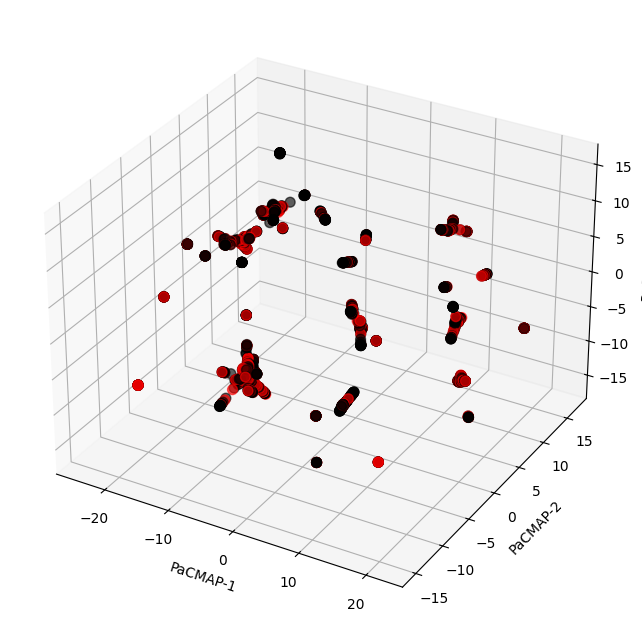

In [9]:
mns_test.plot_qualitative(figsize=(8,8), s=50)

In [10]:
mns_test.to_file("niche.pkl")

In [11]:
mns_test2 = read_pickle("niche.pkl")
mns_test2

NicheSpace(Name:test2, ObservationType: genome, FeatureType: ko, ClassType: genome_cluster)
    * kernel_distance_metric: jaccard
    * scoring_distance_metric: euclidean
    * niche_prefix: n
    * checkpoint_directory: optuna_checkpoints
    * n_neighbors: 224
    * n_components: 91
    * alpha: 0.9636627605010293
    * score: -0.04608364622063325

ko,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,...,n66,n67,n68,n69,n70,n71,n72,n73,n74,n75
genome,,,,,,,,,,,,,,,,,,,,,
fusarium_verticillioides_gca_003316975,-1.077664,-0.495622,-0.716488,0.644398,1.864075,-0.928947,1.553460,0.139566,-0.312433,0.491543,...,0.312366,0.063485,-1.114544,-1.023652,-0.650639,2.342056,0.521664,-3.414353,1.753620,0.128945
fusarium_oxysporum_nrrl_32931_gca_000271745,-1.081386,-0.442052,-0.849496,0.778067,1.658940,-0.998168,1.790610,0.260141,-1.270755,0.142698,...,1.322268,-0.865073,-1.024395,-0.766909,0.340370,-1.139049,-1.697810,-0.141736,0.869117,-0.773970
thermothelomyces_thermophilus_atcc_42464_gca_000226095,-1.081656,-0.393141,-1.008829,0.597538,1.895324,-0.756543,2.021457,0.249260,-1.401778,0.262572,...,0.553774,0.255433,-1.126842,-1.629124,-0.555549,-1.339362,-2.203423,0.454682,0.419250,-0.108314
fusarium_oxysporum_f_sp_cubense_gca_007994515,-1.078909,-0.368959,-1.252789,0.683306,1.763137,-0.298821,1.370288,0.534108,-1.293498,-0.148004,...,0.250726,1.859838,-0.100796,-1.578124,-0.322309,-1.548079,-0.538884,0.908554,0.620724,0.014684
fusarium_coffeatum_gca_003316985,-1.081079,-0.454645,-1.012065,0.828274,1.784094,-0.750725,1.231514,0.085936,-1.289259,-0.102604,...,-0.054456,-0.297859,-1.549992,-0.253578,-0.962067,0.300372,1.086504,-0.823113,1.128703,0.197715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kermadec_Trench_FDZ130_5861_4-6cm_bin.31,0.517105,-3.403456,0.499334,0.596565,-0.255364,1.170731,1.369590,1.227462,-0.009112,0.304205,...,5.632244,0.077856,-3.962003,-0.270139,1.495022,0.323106,0.275002,0.895606,-5.188894,-0.106871
Kermadec_Trench_FDZ130_5861_8-10cm_bin.58,0.565700,-3.385373,-0.230857,1.321070,-0.732550,-0.727104,1.316573,-0.475995,0.841186,-0.191766,...,-1.251789,-3.085275,-2.198099,-3.621731,0.007701,3.703700,-1.530381,4.388884,1.906303,-1.204925
Kermadec_Trench_FDZ127_7600_16-18cm_bin.34,0.688963,-2.672900,-1.345293,0.296205,-1.825698,-3.075759,-0.046016,-0.610089,-2.347949,-0.048816,...,0.530804,2.839325,3.135272,-1.875641,2.983409,2.626042,1.535681,-0.619433,-1.065717,-0.342042


In [18]:
%%time
mns = NicheSpace(
    observation_type="genome",
    feature_type="ko",
    class_type="genome_cluster",
    name="NAL-GDB_MNS_v2",
    n_trials=50,
    n_jobs=-1,
    verbose=10,
)
mns.fit(X_genomic_traits, genome_to_clusterani)
write_pickle(mns, "mns.pkl")

Summing rows by groups: 100%|██████████| 2124/2124 [00:00<00:00, 4630.53 column/s]


2025-02-07 00:32:44,281 - NAL-GDB_MNS_v2 - INFO - [Start] Filtering observations and classes below feature threshold: 100
2025-02-07 00:32:44,498 - NAL-GDB_MNS_v2 - INFO - [Dropping] N = 1114 classes
2025-02-07 00:32:44,503 - NAL-GDB_MNS_v2 - INFO - [Dropping] N = 2073 observations
2025-02-07 00:32:44,504 - NAL-GDB_MNS_v2 - INFO - [Remaining] N = 14860 classes
2025-02-07 00:32:44,504 - NAL-GDB_MNS_v2 - INFO - [Remaining] N = 69598 observations
2025-02-07 00:32:44,505 - NAL-GDB_MNS_v2 - INFO - [Remaining] N = 2124 features
2025-02-07 00:32:44,505 - NAL-GDB_MNS_v2 - INFO - [End] Filtering observations and classes below feature threshold
2025-02-07 00:32:44,671 - NAL-GDB_MNS_v2 - INFO - [Start] Processing distance matrix



KeyboardInterrupt



In [ ]:
# 2025-02-05 23:02:45,318 - NAL-GDB_MNS_v2 - INFO - [Trial 0] Fitting Diffision Map: n_neighbors=279, n_eigenpairs=75, alpha=0.6027633760716439
# 2025-02-05 23:04:42,906 - NAL-GDB_MNS_v2 - INFO - [Trial 0] Transforming observations: n_neighbors=279, n_eigenpairs=75, alpha=0.6027633760716439
# [Trial 0] [Parallel Transformation] Initial data: 100%|██████████| 69598/69598 [14:37<00:00, 79.29it/s]
# 2025-02-05 23:19:22,150 - NAL-GDB_MNS_v2 - INFO - [Trial 0] Calculating silhouette score: n_neighbors=279, n_eigenpairs=75, alpha=0.6027633760716439
# Best trial: 0. Best value: -0.30839:   2%|▏         | 1/50 [17:45<14:30:31, 1065.95s/it]
# [I 2025-02-05 23:20:31,181] Trial 0 finished with value: -0.3083904482292423 and parameters: {'n_neighbors': 279, 'n_eigenpairs': 75, 'alpha': 0.6027633760716439}. Best is trial 0 with value: -0.3083904482292423.

In [ ]:
# Is there a way to save checkpoints for Optuna?

In [ ]:
# Built-In
import warnings

# PyData
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import make_classification
from sklearn.neighbors import kneighbors_graph, KNeighborsTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Metabolic Niche Space
from metabolic_niche_space.neighbors import KNeighborsKernel
from metabolic_niche_space.manifold import DiffusionMaps # Shortcut: from datafold.dynfold import DiffusionMaps

# Create dataset
n_samples = 1000
n_neighbors=int(np.sqrt(n_samples))
X, y = make_classification(n_samples=n_samples, n_features=10, n_classes=2, n_clusters_per_class=1, random_state=0)
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.3)

# Build KNeighbors Kernel
kernel = KNeighborsKernel(metric="euclidean", n_neighbors=30)

# Calculate Diffusion Maps using KNeighbors
model = DiffusionMaps(kernel=kernel, n_eigenpairs=int(np.sqrt(X_training.shape[0])))
dmap_X = model.fit_transform(X_training)
dmap_Y = model.transform(X_testing)

# Shapes
print(dmap_X.shape, dmap_Y.shape)
# (700, 26) (300, 26)

# Plot
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(dmap_X[:,1], dmap_X[:,2], c=list(map(lambda c: {True:"red", False:"black"}[c], y_training)), alpha=0.1, label="Training")
ax.scatter(dmap_Y[:,1], dmap_Y[:,2], c=list(map(lambda c: {True:"red", False:"black"}[c], y_testing)), s = 5, alpha=0.75, label="Testing")
ax.legend()

In [1]:
# Density-Based Clustering Validation Index (for HDBSCAN)
# https://permetrics.readthedocs.io/en/latest/pages/clustering/DBCVI.html
# Intra-Inter Clustering Ratio (IICR)

# Aggregate
# Distance matrix
# Transform
# Optuna
# Save embeddings

# Adjust groupbhy function so it handles dtypes in output
# self.distance function
# function that taes a fitted diffusion map model, transforms X, silhouette score for y
# function that hyperparamter tunes this


#    def _check_param_space(self, estimator, param_space):
#         """
#         estimator: A sklearn-compatible estimator
#         param_space: dict with {name_param: [suggestion_type, *]}
        
#         suggestion_types:  {"categorical", "discrete_uniform", "float", "int", "loguniform", "uniform"}
        
#         categorical suggestion types must contain 2 items (e.g., [categorical, ['a','b','c']])
#         uniform/loguniform suggestion types must contain 3 items [uniform/loguniform, low, high]
#         float/int suggestion type must contain either 3 items [float/int, low, high]) or 4 items [float/int, low, high, {step:float/int, log:bool}]
#         """
#         # suggest_categorical()
#         # Suggest a value for the categorical parameter.
#         # suggest_discrete_uniform(name, low, high, q)
#             # Suggest a value for the discrete parameter.
#         # suggest_float(name, low, high, *[, step, log])
#             # Suggest a value for the floating point parameter.
#         # suggest_int(name, low, high, *[, step, log])
#             # Suggest a value for the integer parameter.
#         # suggest_loguniform(name, low, high)
#             # Suggest a value for the continuous parameter.
#         # suggest_uniform(name, low, high)
#             # Suggest a value for the continuous parameter.
        
#         # Check if parameter names are valid
#         param_space = copy.deepcopy(param_space)
#         estimator_params = set(estimator.get_params(deep=True).keys())
#         query_params = set(param_space.keys())
#         assert query_params <= estimator_params, "The following parameters are not recognized for estimator {}:\n{}".format(estimator.__class__.__name__, "\n".join(sorted(query_params - estimator_params)))

#         suggestion_types = {"categorical", "discrete_uniform", "float", "int", "loguniform", "uniform"}
#         for k, v in param_space.items():
#             assert hasattr(v, "__iter__") & (not isinstance(v, str)), "space must be iterable"
#             assert len(v) > 1, "space must use the following format: [suggestion_type, *values] (e.g., [categorical, ['a','b','c']]\n[int, 1, 100])"
#             query_suggestion_type = v[0]
#             assert_acceptable_arguments(query_suggestion_type, suggestion_types)
#             if query_suggestion_type in {"categorical"}:
#                 assert len(v) == 2, "categorical suggestion types must contain 2 items (e.g., [categorical, ['a','b','c']])"
#                 assert hasattr(v[1], "__iter__") & (not isinstance(v[1], str)), "categorical suggestion types must contain 2 items [categorical, ['a','b','c']]"
#             if query_suggestion_type in {"uniform", "loguniform"}:
#                 assert len(v) == 3, "uniform/loguniform suggestion types must contain 3 items [uniform/loguniform, low, high]"
#             if query_suggestion_type in {"discrete_uniform"}:
#                 assert len(v) == 4, "discrete_uniform suggestion type must contain 4 items [discrete_uniform, low, high, q]"
#             if query_suggestion_type in {"float", "int"}:
#                 suggest_float_int_error_message = "float/int suggestion type must contain either 3 items [float/int, low, high]) or 4 items [float/int, low, high, {step:float/int, log:bool}]"
#                 assert len(v) in {3,4}, suggest_float_int_error_message
#                 if len(v) == 3:
#                     param_space[k] = [*v, {}]
#                 if len(v) == 4:
#                     query_dict = v[-1]
#                     assert isinstance(query_dict, Mapping), suggest_float_int_error_message
#                     query_dict = dict(query_dict)
#                     assert set(query_dict.keys()) <= {"step", "log"}, suggest_float_int_error_message
#                     if "step" in query_dict:
#                         assert isinstance(query_dict["step"], (float, int)), suggest_float_int_error_message
#                     if "log" in query_dict:
#                         assert isinstance(query_dict["log"], bool), suggest_float_int_error_message
#                     param_space[k] = [*v[:-1], query_dict]
#         return param_space

#     def _compile_param_space(self, trial, param_space):
#         params = dict()
#         for k, v in param_space.items():
#             suggestion_type = v[0]
#             suggest = getattr(trial, f"suggest_{suggestion_type}")
#             if suggestion_type in {"float", "int"}:
#                 suggestion = suggest(k, *v[1:-1], **v[-1])
#             else:
#                 suggestion = suggest(k, *v[1:])
#             params[k] = suggestion
#         return params

#     def _optimize_hyperparameters(self, X, y, study_name, sampler, **study_kws): # test set here?
#         def _objective(trial):

#             # Compile parameters
#             params = self._compile_param_space(trial, self.param_space)

#             estimator = clone(self.estimator)
#             estimator.set_params(**params)

#             cv_results = cross_val_score(estimator, X, y, scoring=self.scorer, n_jobs=self.n_jobs, cv=self.cv_splits_)

#             return cv_results.mean()
            
#         direction = "maximize"
#         study = optuna.create_study(direction=direction, study_name=study_name, sampler=sampler, **study_kws)
#         study.optimize(_objective, n_trials=self.n_trials, timeout=self.study_timeout, show_progress_bar=self.verbose >= 2, callbacks=self.study_callbacks, gc_after_trial=True)
#         return study

NICHE_SPACE_PARAMETER_SPACE=dict()
class NicheSpace(object):
    def __init__(
        self, 
        name:str=None,
        observation_type:str=None,
        feature_type:str=None,
        class_type:str=None,
        params:dict="auto",
        params_space:dict=NICHE_SPACE_PARAMETER_SPACE,
        distance_metric:str="jaccard",
        cluster_metric:str="silhouette", # or 
        ):
        self.name = name
        self.node_type = node_type
        self.edge_type = edge_type
        self.is_fitted = False

    def fit(
        self,
        ):
      
        self.is_fitted = True

        return self
        
    def fit_transform(
        self,
     
        return self.embeddings_

    # Convert
    # =======

    # =======
    # Built-in
    # =======
#     def __repr__(self):
#         pad = 4
#         header = format_header("ClusteredNetwork(Name:{}, NodeType: {}, EdgeType: {})".format(self.name, self.node_type, self.edge_type),line_character="=")

#         n = len(header.split("\n")[0])
#         fields = [
#             header,
#         ]
#         if self.is_fitted:
#             fields += [
#             pad*" " + "* Algorithm: {}".format(self.algorithm),
#             pad*" " + "* Minimum edge cooccurrence rate: {}".format(self.minimum_cooccurrence_rate),
#             pad*" " + "* Number of iterations: {}".format(self.n_iter),
#             pad*" " + "* Number of nodes clustered: {} ({:0.2f}%)".format(self.number_of_nodes_clustered_, 100*(self.number_of_nodes_clustered_/self.number_of_nodes_initial_)),
#             pad*" " + "* Number of edges clustered: {} ({:0.2f}%)".format(self.number_of_edges_clustered_, 100*(self.number_of_edges_clustered_/self.number_of_edges_initial_)),
            
#             *map(lambda line:pad*" " + line, format_header("| Cluster Sizes (N = {})".format(self.number_of_clusters_), "-", n=n-pad).split("\n")),
#             *map(lambda line: pad*" " + line, repr(self.cluster_sizes_).split("\n")[:-1]),
#             ]

#         return "\n".join(fields)

SyntaxError: invalid syntax (2425045402.py, line 46)

In [14]:
# class MetabolicFunctionalType? or general

In [17]:
import logging
def build_logger(logger_name=__name__, stream=sys.stdout, level=logging.INFO):
    """
    Build a logger object that outputs to a given stream.
    If a logger with the same name already exists, it is overwritten.

    Args:
        logger_name (str, optional): Name of the logger. Defaults to __name__.
        stream (TextIO, optional): Where to output the logs. Defaults to sys.stdout.

    Returns:
        logging.Logger: The logger object.
    """
    # Check if the logger already exists and remove its handlers
    if logger_name in logging.root.manager.loggerDict:
        existing_logger = logging.getLogger(logger_name)
        for handler in existing_logger.handlers[:]:
            existing_logger.removeHandler(handler)
    
    # Create or overwrite the logger
    logger = logging.getLogger(logger_name)
    logger.setLevel(level)  # Set the logging level

    # Create a stream handler to output logs to stdout
    stream_handler = logging.StreamHandler(stream)
    stream_handler.setLevel(level)  # Set the level for the handler

    # Create a formatter and set it to the handler
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    stream_handler.setFormatter(formatter)

    # Add the handler to the logger
    logger.addHandler(stream_handler)

    return logger
logger = build_logger("whatup")
logger.info("FUCK")

2025-02-06 19:28:06,548 - whatup - INFO - FUCK


In [18]:
logger = build_logger("whatup")
logger.info("FUCK")

2025-02-06 19:28:10,200 - whatup - INFO - FUCK


In [ ]:
def read_list(filepath, into=list, compression="auto"):
    contents = list()
    with open_file_reader(filepath, compression=compression) as f:
        for line in f:
            line = line.strip()
            if line:
                contents.append(line.strip())
    return into(contents)